In [48]:
import json
from typing import List

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from rich import print
import matplotlib.pyplot as plt

from src.blip_modules.blip_text_encoder import BLIPTextEncoder
from src.blip_modules.blip_img_encoder import BLIPImgEncoder
from src.data_utils import targetpad_transform
from src.fashioniq_experiment.utils import element_wise_sum_original, element_wise_sum, get_combing_function_with_alpha, \
    convert_to_pivot_fiq, prepare_and_plot_recall_pivot, prepare_ground_truths, plot_retrieval_results_of_i, \
    found_better_than_original
from src.fashioniq_experiment.validate_notebook import fiq_val_retrieval_text_image_grid_search, compute_results_fiq_val
from src.utils import device

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 1: Set up the experiment</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Set up the cache for the experiment</div>

In [2]:
cache = {}

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Same concept as script version here</div>

In [3]:
BLIP_PRETRAINED_PATH = '../../../models/model_base.pth'
MED_CONFIG_PATH = '../../blip_modules/med_config.json'

In [4]:
blip_text_encoder = BLIPTextEncoder(
    BLIP_PRETRAINED_PATH, 
    MED_CONFIG_PATH,
    use_pretrained_proj_layer=True
)

blip_text_encoder = blip_text_encoder.to(device)
print("blip text encoder loaded.")
blip_text_encoder.eval()

load checkpoint from ../../../models/model_base.pth for text_encoder.
load checkpoint from ../../../models/model_base.pth for text_proj.


blip text encoder loaded.

BLIPTextEncoder(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30524, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Drop

In [5]:
blip_img_encoder = BLIPImgEncoder(BLIP_PRETRAINED_PATH)
blip_img_encoder = blip_img_encoder.to(device)
print("blip img encoder loaded.")
blip_img_encoder.eval()

reshape position embedding from 196 to 576
load checkpoint from ../../../models/model_base.pth for visual_encoder.
load checkpoint from ../../../models/model_base.pth for vision_proj.


blip img encoder loaded.

BLIPImgEncoder(
  (visual_encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
      

In [6]:
print('Target pad preprocess pipeline is used')
preprocess = targetpad_transform(1.25, 384)

Target pad preprocess pipeline is used

In [7]:
combining_function_original = element_wise_sum_original

In [8]:
combining_function = lambda image_features, text_features: element_wise_sum(image_features, text_features, alpha=0.65)

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 2: Load the MLLM generated text captions</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Load the addition text captions</div>

In [9]:
with open('../../../fashionIQ_dataset/labeled_images_cir_cleaned.json', 'r') as f:
    text_captions = json.load(f)
    
total_recall_list: List[List[pd.DataFrame]] = []

print(f'Total number of text captions: {len(text_captions)}')

Total number of text captions: 74357

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 3: Perform retrieval on the FashionIQ dataset</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the shirt category</div>

In [10]:
grid_search_alphas = np.arange(0, 1.05, 0.05)
shirt_recall_list: List[pd.DataFrame] = []

for alpha in tqdm(grid_search_alphas, desc="Grid Search alphas and betas"):
    shirt_recall = fiq_val_retrieval_text_image_grid_search(
        'shirt',
        get_combing_function_with_alpha(alpha),
        blip_text_encoder,
        blip_img_encoder,
        text_captions,
        preprocess,
        cache=cache,
    )
    
    shirt_recall_list.append(shirt_recall)

shirt_recall_at10, shirt_recall_at50 = convert_to_pivot_fiq(shirt_recall_list)

Grid Search alphas and betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [11]:
display(shirt_recall_at10, shirt_recall_at50)

alpha      0.00      0.05      0.10      0.15      0.20      0.25      0.30  \
beta                                                                          
0.00   7.605495  7.605495  7.703631  7.752699  7.801767  7.801767  7.850834   
0.05   7.605495  7.703631  7.801767  7.752699  7.752699  7.801767  7.948969   
0.10   7.409225  7.556428  7.703631  7.654563  7.801767  8.047105  8.145241   
0.15   7.556428  7.605495  7.801767  7.899902  8.145241  8.243376  8.390579   
0.20   7.507360  7.605495  7.850834  7.998037  8.194308  8.635917  8.684985   
0.25   7.654563  7.654563  7.703631  7.850834  8.194308  8.390579  8.783121   
0.30   7.556428  7.703631  7.801767  7.703631  7.998037  8.243376  8.684985   
0.35   7.311089  7.556428  7.752699  8.194308  8.439647  8.488715  8.881256   
0.40   7.065751  7.311089  7.556428  7.899902  8.341511  8.635917  9.028459   
0.45   6.820412  7.114819  7.458293  7.801767  8.341511  8.635917  9.224730   
0.50   7.065751  7.262021  7.409225  7.654563  8.096173  8.586850  9.175663   
0.55   6.869480  7.262021  7.507360  7.605495  8.047105  8.439647  9.028459   
0.60   6.526006  6.918547  7.212954  7.654563  7.899902  8.488715  9.273798   
0.65   6.231600  6.427871  7.065751  7.507360  7.948969  8.439647  9.224730   
0.70   6.231600  6.427871  6.869480  7.311089  7.703631  8.292443  8.979391   
0.75   5.888126  6.280667  6.476938  7.114819  7.556428  8.096173  8.979391   
0.80   5.789990  6.133464  6.329735  6.771345  7.212954  7.850834  8.488715   
0.85   5.789990  5.937193  6.035329  6.624141  7.311089  7.752699  8.341511   
0.90   5.642787  5.839058  6.133464  6.673209  7.311089  7.850834  8.243376   
0.95   5.691855  5.593719  5.937193  6.329735  6.869480  7.703631  7.850834   
1.00   5.348381  5.446516  5.789990  6.133464  6.476938  7.163886  7.507360   

alpha       0.35       0.40       0.45  ...       0.55       0.60       0.65  \
beta                                    ...                                    
0.00    8.047105   8.096173   8.145241  ...   8.586850   8.734053   9.175663   
0.05    7.948969   8.194308   8.439647  ...   8.930324   9.175663   9.813543   
0.10    8.194308   8.635917   8.832189  ...   9.421001   9.813543  10.451423   
0.15    8.488715   8.832189   9.077527  ...   9.813543  10.255152  10.942100   
0.20    8.979391   9.077527   9.470069  ...  10.304220  10.893033  11.187439   
0.25    8.979391   9.322865   9.764475  ...  10.598626  10.696761  11.432777   
0.30    9.077527   9.421001   9.813543  ...  10.794897  11.089303  12.070657   
0.35    9.322865   9.862611  10.549559  ...  10.991168  11.629048  12.659471   
0.40    9.421001   9.813543  10.500491  ...  11.678116  12.414131  13.346419   
0.45    9.862611  10.009813  10.794897  ...  11.923455  13.101080  13.738960   
0.50    9.911678  10.402355  11.040235  ...  12.266929  13.248283  14.573111   
0.55    9.764475  10.647694  11.285574  ...  12.953876  13.689892  14.818449   
0.60   10.304220  10.794897  11.089303  ...  13.150147  14.131501  14.965652   
0.65   10.058881  10.794897  11.530913  ...  13.542689  14.376840  15.260059   
0.70    9.911678  11.040235  11.776251  ...  13.935231  14.769381  15.750736   
0.75    9.617272  10.942100  12.070657  ...  13.591756  14.720315  15.701668   
0.80    9.617272  10.598626  12.070657  ...  13.689892  14.720315  15.063788   
0.85    9.224730  10.402355  11.432777  ...  13.444553  14.278704  14.573111   
0.90    9.273798  10.255152  11.089303  ...  13.101080  13.738960  14.327772   
0.95    8.783121   9.813543  10.598626  ...  13.052012  13.297351  13.689892   
1.00    8.096173   9.175663  10.157017  ...  12.610403  13.199215  13.346419   

alpha       0.70       0.75       0.80       0.85       0.90       0.95  \
beta                                                                      
0.00    9.911678  10.549559  11.825319  13.837095  16.830225  21.148184   
0.05   10.353287  11.432777  12.463199  14.573111  17.664377  21.982336   
0.10   11.040235  11.776251  13.052012  1

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   16.437684  16.535820  16.732091  16.977429  17.320903  17.468105   
0.05   16.830225  16.977429  17.271835  17.369971  17.369971  17.664377   
0.10   17.271835  17.320903  17.566241  17.664377  17.909716  18.056919   
0.15   17.419039  17.615309  17.664377  17.713444  18.204121  18.302257   
0.20   17.713444  17.909716  18.056919  18.449460  18.596664  19.038273   
0.25   17.664377  18.056919  18.351325  18.940137  19.038273  19.234544   
0.30   17.909716  18.302257  18.694799  18.891069  18.989205  19.479883   
0.35   17.762512  18.105987  18.449460  18.989205  19.332679  19.921492   
0.40   17.811580  18.007851  18.645731  19.381747  19.627085  20.264965   
0.45   17.419039  18.007851  18.694799  19.528949  19.774288  20.215897   
0.50   17.173700  17.664377  18.351325  19.234544  19.676153  20.215897   
0.55   16.339548  17.369971  18.105987  18.891069  19.627085  20.755643   
0.60   16.143277  16.830225  17.369971  18.498528  19.528949  20.804711   
0.65   15.750736  16.437684  17.222768  18.056919  19.430815  20.559372   
0.70   15.309127  16.094211  16.781157  17.909716  19.283612  20.559372   
0.75   14.622179  15.554465  16.486752  17.271835  18.596664  19.921492   
0.80   13.984299  14.769381  15.456329  16.633955  17.909716  19.136408   
0.85   13.248283  14.131501  15.210991  15.750736  17.124632  18.204121   
0.90   12.414131  13.493621  14.474976  15.161924  16.584887  17.517173   
0.95   12.021590  12.806673  13.591756  14.376840  15.260059  16.683023   
1.00   11.481845  12.070657  13.199215  14.082433  14.867517  15.750736   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   17.566241  17.664377  17.713444  17.958783  ...  18.449460  18.940137   
0.05   17.909716  18.007851  18.302257  18.645731  ...  18.989205  20.019627   
0.10   18.253189  18.498528  18.743867  19.038273  ...  20.215897  20.755643   
0.15   18.498528  18.743867  19.430815  19.872424  ...  20.804711  21.050049   
0.20   19.087340  19.332679  19.627085  20.264965  ...  21.491659  22.325809   
0.25   19.479883  19.774288  20.264965  20.951913  ...  22.473013  23.307164   
0.30   20.068695  20.314033  20.951913  21.393523  ...  23.552503  23.994112   
0.35   20.461236  21.000981  21.246320  22.325809  ...  24.337585  25.024533   
0.40   20.902845  21.638861  22.374877  23.061825  ...  24.926399  25.858685   
0.45   21.050049  22.129539  22.620216  23.650637  ...  25.417075  26.741904   
0.50   21.295388  22.276741  22.571148  23.994112  ...  26.300293  27.576056   
0.55   21.786065  22.227675  23.061825  24.435721  ...  27.085379  28.361139   
0.60   21.933268  22.522080  23.503435  24.926399  ...  27.821395  29.048085   
0.65   21.687929  22.963689  23.797841  24.975467  ...  28.753680  29.833171   
0.70   21.491659  22.473013  23.405299  25.269872  ...  28.410205  29.980373   
0.75   20.804711  21.884200  22.963689  24.631992  ...  28.508341  30.225712   
0.80   20.019627  21.246320  22.718351  24.631992  ...  28.508341  29.735035   
0.85   19.479883  20.853779  22.522080  24.092247  ...  27.772325  28.900883   
0.90   18.743867  20.755643  22.031404  23.356232  ...  26.594701  27.625123   
0.95   17.615309  19.627085  21.540727  22.865555  ...  25.711483  26.398429   
1.00   16.977429  19.087340  20.510304  21.933268  ...  24.484789  25.466144   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   19.823356  20.608440  22.129539  23.945044  26.692837  31.795877   
0.05   20.559372  21.589793  23.110893  24.828263  27.870461  33.562315   
0.10   21.197252  22.473013  23.945044  26.104024  29.391560  34.838077   
0.15   22.227675  23.503435  24.877331  27.085379  30.8145

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the dress category</div>

In [12]:
grid_search_alphas = np.arange(0, 1.05, 0.05)
dress_recall_list: List[pd.DataFrame] = []

for alpha in tqdm(grid_search_alphas, desc="Grid Search alphas and betas"):
    dress_recall = fiq_val_retrieval_text_image_grid_search(
        'dress',
        get_combing_function_with_alpha(alpha),
        blip_text_encoder,
        blip_img_encoder,
        text_captions,
        preprocess,
        cache=cache,
    )
    
    dress_recall_list.append(dress_recall)

dress_recall_at10, dress_recall_at50 = convert_to_pivot_fiq(dress_recall_list)

Grid Search alphas and betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [13]:
display(dress_recall_at10, dress_recall_at50)

alpha      0.00      0.05      0.10      0.15      0.20      0.25      0.30  \
beta                                                                          
0.00   4.660387  4.709965  4.709965  4.809123  4.858701  4.908280  4.957858   
0.05   4.759544  4.809123  4.908280  4.908280  4.908280  4.957858  4.858701   
0.10   4.462072  4.561229  4.610808  4.809123  4.858701  4.858701  4.858701   
0.15   4.362915  4.362915  4.561229  4.660387  4.759544  4.957858  5.057015   
0.20   4.313337  4.263758  4.313337  4.412494  4.561229  4.660387  4.908280   
0.25   4.015865  4.065444  4.214180  4.362915  4.462072  4.561229  4.660387   
0.30   3.767972  3.817551  3.916708  4.115022  4.362915  4.561229  4.660387   
0.35   3.867129  3.966286  4.015865  4.015865  3.966286  4.214180  4.660387   
0.40   3.668815  3.867129  3.817551  3.867129  4.065444  4.214180  4.561229   
0.45   3.668815  3.817551  3.817551  3.817551  3.966286  4.065444  4.313337   
0.50   3.272187  3.520079  3.767972  3.718394  3.767972  4.015865  4.164601   
0.55   3.024293  3.272187  3.520079  3.470501  3.569658  4.015865  4.115022   
0.60   2.825979  3.222608  3.420922  3.520079  3.569658  3.718394  3.916708   
0.65   2.726822  2.925136  2.925136  3.173029  3.222608  3.668815  4.015865   
0.70   2.478929  2.578086  2.776401  2.925136  3.073872  3.371344  3.520079   
0.75   2.330193  2.429350  2.627665  2.578086  2.875558  3.272187  3.470501   
0.80   2.330193  2.528508  2.627665  2.578086  2.825979  3.024293  3.321765   
0.85   2.330193  2.379772  2.429350  2.528508  2.726822  2.875558  2.974715   
0.90   2.181458  2.131879  2.280615  2.280615  2.429350  2.578086  2.875558   
0.95   2.032722  1.883986  2.082300  2.231036  2.181458  2.379772  2.578086   
1.00   1.685672  1.784829  1.933565  2.032722  2.181458  2.181458  2.379772   

alpha      0.35      0.40      0.45  ...      0.55      0.60      0.65  \
beta                                 ...                                 
0.00   4.957858  4.908280  5.007437  ...  5.156172  5.255330  5.602380   
0.05   4.858701  4.908280  4.858701  ...  5.255330  5.552801  6.197323   
0.10   4.809123  4.858701  5.156172  ...  5.503223  5.850273  6.197323   
0.15   5.057015  5.304908  5.354487  ...  5.800694  6.246901  6.445216   
0.20   5.057015  5.255330  5.503223  ...  5.850273  6.445216  6.841844   
0.25   5.007437  5.205751  5.354487  ...  5.999009  6.643530  6.891423   
0.30   4.709965  5.057015  5.453644  ...  5.949430  6.494794  7.337630   
0.35   4.858701  5.156172  5.205751  ...  5.999009  6.643530  7.486366   
0.40   4.957858  5.057015  5.205751  ...  6.098166  6.742688  7.734258   
0.45   4.610808  4.858701  5.255330  ...  5.701537  7.089737  7.833416   
0.50   4.164601  4.660387  4.957858  ...  5.899851  6.693108  7.635102   
0.55   4.214180  4.313337  4.908280  ...  5.751115  6.593952  7.734258   
0.60   4.115022  4.263758  4.660387  ...  5.899851  6.494794  7.486366   
0.65   4.313337  4.313337  4.809123  ...  5.800694  6.643530  7.535944   
0.70   4.065444  4.313337  4.809123  ...  5.800694  6.296480  7.238473   
0.75   3.817551  3.966286  4.610808  ...  5.404066  6.346059  7.040159   
0.80   3.520079  3.767972  4.462072  ...  5.304908  6.346059  6.990580   
0.85   3.420922  3.916708  4.313337  ...  5.106594  5.949430  6.197323   
0.90   3.371344  3.916708  4.115022  ...  4.709965  5.453644  6.048587   
0.95   2.974715  3.470501  3.867129  ...  4.263758  5.106594  5.651958   
1.00   2.875558  3.371344  3.470501  ...  4.065444  4.809123  5.156172   

alpha      0.70       0.75       0.80       0.85       0.90       0.95  \
beta                                                                     
0.00   6.445216   7.089737   8.329201  10.659395  14.923154  19.583540   
0.05   6.494794   7.436787   8.924145  11.353495  15.418939  20.128904   
0.10   6.792266   8.130887   9.320773  11.650967  16.509669  20.525533   
0.15   7.139315   8.626673   9.915716  12.543382  17.253347  20.575112   
0.20   7.833416   8.973724  10.5106

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   11.403074  11.551809  11.700545  11.750124  11.700545  11.849281   
0.05   11.303917  11.452653  11.948438  11.998017  12.196331  12.394646   
0.10   11.750124  11.948438  12.047596  12.394646  12.741695  12.791274   
0.15   11.898860  12.097174  12.047596  12.295488  12.592959  12.890431   
0.20   11.700545  11.849281  11.998017  12.295488  12.692118  12.940010   
0.25   11.502231  11.650967  11.898860  12.345067  12.592959  13.088746   
0.30   11.403074  11.750124  12.146752  12.345067  12.543382  12.791274   
0.35   11.303917  11.452653  11.799703  12.196331  12.444224  12.989588   
0.40   11.006445  11.452653  11.898860  12.345067  12.642539  13.039167   
0.45   10.461081  11.155181  11.750124  12.047596  12.444224  12.741695   
0.50   10.361923  11.006445  11.452653  11.998017  12.295488  12.741695   
0.55    9.766981  10.461081  10.808131  11.303917  12.097174  12.394646   
0.60    9.469509   9.866138  10.411502  10.907288  11.601388  11.898860   
0.65    8.924145   9.469509   9.717402  10.659395  11.056024  11.551809   
0.70    8.527516   8.973724   9.519088   9.915716  10.510659  11.006445   
0.75    8.230045   8.577095   9.072880   9.469509  10.064452  10.708974   
0.80    7.734258   8.230045   8.527516   9.072880   9.618245  10.114031   
0.85    7.188895   7.387209   7.882994   8.775409   9.221616   9.816559   
0.90    6.792266   7.188895   7.535944   8.230045   8.577095   9.023302   
0.95    6.346059   6.792266   7.139315   7.535944   8.230045   8.180466   
1.00    5.701537   6.147744   6.693108   7.337630   7.684680   7.783838   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   12.047596  12.543382  12.692118  13.039167  ...  13.782845  14.526525   
0.05   12.592959  12.940010  13.187903  13.485375  ...  14.526525  15.071888   
0.10   13.039167  13.237481  13.435796  13.882002  ...  14.675260  15.666832   
0.15   13.435796  13.435796  13.782845  14.030738  ...  15.071888  15.914725   
0.20   13.386217  13.634109  13.832425  14.328210  ...  15.964304  17.302924   
0.25   13.187903  13.683689  14.030738  14.675260  ...  17.005454  18.046604   
0.30   13.039167  13.931581  14.278631  14.823996  ...  17.402083  18.443233   
0.35   13.336639  13.931581  14.625682  15.220624  ...  17.402083  18.591969   
0.40   13.634109  13.931581  14.675260  15.468517  ...  17.302924  19.038175   
0.45   13.287060  13.981161  15.071888  15.617253  ...  17.451660  18.839861   
0.50   13.039167  13.782845  14.675260  15.468517  ...  18.195340  19.186911   
0.55   12.741695  13.634109  14.476946  15.319782  ...  17.997025  19.682696   
0.60   12.642539  13.485375  14.229053  15.319782  ...  18.195340  19.335647   
0.65   11.998017  12.840852  13.782845  14.972731  ...  17.897868  19.186911   
0.70   11.403074  12.493803  13.485375  14.427367  ...  16.807139  18.591969   
0.75   11.105602  11.750124  13.039167  14.030738  ...  16.212197  17.897868   
0.80   10.609817  11.204760  12.146752  13.237481  ...  15.567675  17.253347   
0.85    9.965295  10.708974  11.601388  12.840852  ...  14.823996  16.113040   
0.90    9.370352  10.163610  11.254338  12.444224  ...  14.476946  15.418939   
0.95    8.824988   9.370352  10.361923  11.254338  ...  13.336639  14.278631   
1.00    8.477937   8.973724   9.568667  10.461081  ...  12.543382  13.386217   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   15.270203  16.757561  18.393654  20.922162  24.194348  31.333664   
0.05   16.311353  17.798711  19.186911  21.814576  25.235498  32.870600   
0.10   17.104611  18.641546  20.178483  22.756569  26.921171  33.862171   
0.15   17.848289  19.385226  21.070898  23.797719  28.1606

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the toptee category</div>

In [14]:
grid_search_alphas = np.arange(0, 1.05, 0.05)
toptee_recall_list: List[pd.DataFrame] = []

for alpha in tqdm(grid_search_alphas, desc="Grid Search alphas and betas"):
    toptee_recall = fiq_val_retrieval_text_image_grid_search(
        'toptee',
        get_combing_function_with_alpha(alpha),
        blip_text_encoder,
        blip_img_encoder,
        text_captions,
        preprocess,
        cache=cache,
    )
    
    toptee_recall_list.append(toptee_recall)
    
toptee_recall_at10, toptee_recall_at50 = convert_to_pivot_fiq(toptee_recall_list)

Grid Search alphas and betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [15]:
display(toptee_recall_at10, toptee_recall_at50)

alpha      0.00      0.05      0.10      0.15      0.20      0.25      0.30  \
beta                                                                          
0.00   6.578276  6.629271  6.578276  6.578276  6.629271  6.629271  6.680265   
0.05   6.323305  6.323305  6.374299  6.425294  6.476288  6.578276  6.527282   
0.10   6.170321  6.221316  6.221316  6.221316  6.323305  6.527282  6.680265   
0.15   6.170321  6.221316  6.374299  6.476288  6.476288  6.527282  6.680265   
0.20   5.915349  6.017338  6.119327  6.476288  6.578276  6.731260  6.884243   
0.25   5.864355  6.068332  6.272310  6.476288  6.578276  6.782254  6.935237   
0.30   5.762366  5.915349  6.017338  6.170321  6.731260  6.833249  7.088220   
0.35   5.711372  5.711372  6.068332  6.221316  6.731260  6.731260  7.088220   
0.40   5.507394  5.660377  5.813361  6.119327  6.374299  6.425294  6.986231   
0.45   5.150434  5.456400  5.762366  5.864355  6.170321  6.374299  6.884243   
0.50   4.997450  5.252422  5.456400  6.017338  6.272310  6.731260  7.394186   
0.55   4.640489  5.150434  5.711372  5.762366  6.272310  6.833249  7.802141   
0.60   4.589495  4.793473  5.303417  5.609383  6.272310  6.782254  7.751147   
0.65   4.487506  4.895461  4.997450  5.252422  5.915349  6.374299  7.241204   
0.70   4.232534  4.538501  4.844467  5.048444  5.609383  6.323305  7.037226   
0.75   3.977562  4.232534  4.487506  4.895461  5.354411  6.017338  6.629271   
0.80   3.926568  4.028557  4.232534  4.691484  5.252422  5.966344  6.476288   
0.85   3.620602  3.875574  3.977562  4.538501  5.099439  5.558389  6.068332   
0.90   3.212647  3.569607  3.926568  4.181540  4.640489  5.303417  5.762366   
0.95   2.804692  3.161652  3.518613  4.028557  4.436512  4.946456  5.558389   
1.00   2.600714  2.804692  2.957675  3.518613  3.977562  4.487506  5.099439   

alpha      0.35      0.40       0.45  ...       0.55       0.60       0.65  \
beta                                  ...                                    
0.00   6.782254  6.935237   7.088220  ...   7.445181   7.751147   8.006119   
0.05   6.833249  6.935237   7.139215  ...   7.649159   7.853136   8.108108   
0.10   6.935237  7.241204   7.547170  ...   8.057114   8.363080   8.924019   
0.15   7.088220  7.496175   7.751147  ...   8.414075   8.873024   9.535951   
0.20   7.292198  7.700153   8.057114  ...   8.924019   9.280979  10.759816   
0.25   7.445181  7.853136   8.261091  ...   9.739929  10.453850  11.524732   
0.30   7.547170  8.006119   8.720041  ...  10.351861  11.065783  12.340643   
0.35   7.700153  8.006119   8.822030  ...  10.453850  11.575726  13.360530   
0.40   7.547170  8.312086   9.077001  ...  11.116777  12.442631  14.584395   
0.45   7.547170  8.822030   9.637940  ...  11.728710  13.360530  15.298317   
0.50   8.108108  9.077001  10.147884  ...  12.544620  14.533402  16.114227   
0.55   8.567058  9.127996  10.555839  ...  13.207547  15.247323  16.420195   
0.60   8.618052  9.229985  10.096889  ...  14.125445  15.451300  16.828150   
0.65   8.363080  9.178990  10.606834  ...  14.482407  15.553290  16.777155   
0.70   7.904130  9.026007  10.249873  ...  14.329425  15.349312  16.828150   
0.75   7.649159  8.567058  10.606834  ...  13.870475  15.043345  16.726160   
0.80   7.394186  8.822030  10.096889  ...  13.819480  14.890362  16.369200   
0.85   6.833249  8.261091   9.586945  ...  13.411525  14.839368  15.706272   
0.90   6.935237  8.006119   9.382968  ...  12.748598  14.329425  15.400305   
0.95   6.680265  7.700153   9.280979  ...  12.544620  14.023457  14.737380   
1.00   6.272310  7.343192   8.720041  ...  12.136665  13.462520  13.513513   

alpha       0.70       0.75       0.80       0.85       0.90       0.95  \
beta                                                                      
0.00    8.363080   9.688934  11.677715  14.941357  19.530852  23.355430   
0.05    9.382968  10.504845  12.595615  16.012238  20.703723  24.579297   
0.10    9.841917  11.422744  13.870475  17.389087  22.029577  24.936257   
0.15   10.75

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   14.380418  14.533402  14.686385  14.788373  14.839368  15.043345   
0.05   14.533402  14.686385  14.941357  14.941357  15.094340  15.451300   
0.10   14.584395  14.890362  14.992350  15.196328  15.604283  15.808260   
0.15   14.788373  15.043345  15.553290  15.859255  16.012238  16.369200   
0.20   14.941357  15.196328  15.553290  16.012238  16.318205  16.828150   
0.25   14.482407  14.788373  15.094340  15.808260  16.369200  16.879143   
0.30   14.635390  15.094340  15.451300  16.114227  16.828150  17.287098   
0.35   14.329425  14.890362  15.502295  16.114227  16.930138  17.491075   
0.40   13.819480  14.584395  15.349312  16.063233  16.777155  17.644060   
0.45   13.717490  14.380418  15.349312  15.910250  16.879143  17.746048   
0.50   13.309535  13.717490  14.329425  15.502295  16.522183  17.797042   
0.55   12.850587  13.513513  14.380418  15.247323  16.216215  17.542070   
0.60   12.544620  13.207547  14.023457  14.941357  16.165222  17.236105   
0.65   12.085670  12.901580  13.411525  14.380418  15.502295  16.828150   
0.70   11.575726  12.493626  13.156553  13.870475  14.839368  16.216215   
0.75   10.963794  11.932687  12.646610  13.462520  14.329425  15.961245   
0.80   10.300867  11.320755  12.187659  13.105558  13.615502  15.043345   
0.85    9.892911  10.453850  11.371749  12.187659  13.309535  14.635390   
0.90    9.586945  10.300867  11.116777  11.983681  12.697603  14.329425   
0.95    9.178990   9.943906  10.657828  11.524732  12.289649  13.513513   
1.00    8.669046   9.331974  10.045895  10.912800  11.473738  13.054565   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   15.145335  15.502295  15.961245  16.471188  ...  17.491075  18.204997   
0.05   15.961245  16.267210  16.726160  17.032127  ...  18.510965  19.071902   
0.10   16.012238  16.777155  17.083120  17.593065  ...  19.275880  20.091790   
0.15   16.981132  17.389087  17.797042  18.408975  ...  20.193778  21.111678   
0.20   17.287098  17.695053  18.306985  19.428863  ...  21.213667  22.692505   
0.25   17.797042  18.255992  18.867925  19.785823  ...  22.590515  23.763385   
0.30   18.052015  18.663947  19.581845  20.601735  ...  23.814380  25.752166   
0.35   18.459970  19.173890  20.193778  21.468638  ...  24.936257  27.231005   
0.40   18.204997  19.479857  20.550740  22.182560  ...  26.364100  27.995920   
0.45   18.867925  19.581845  21.009690  22.998470  ...  27.078021  29.066804   
0.50   18.765935  19.989800  21.060683  23.457420  ...  28.403875  29.984701   
0.55   18.816930  20.091790  21.774605  24.681285  ...  28.658849  30.800611   
0.60   18.663947  20.499745  21.978582  25.089240  ...  29.015809  31.922489   
0.65   18.561958  20.448750  22.590515  25.038245  ...  29.474759  32.126465   
0.70   17.746048  19.836818  22.335543  24.630290  ...  30.137685  32.279450   
0.75   17.746048  19.377868  22.131565  24.732280  ...  30.137685  32.432431   
0.80   17.542070  19.071902  21.825600  24.426313  ...  30.035695  31.871495   
0.85   16.879143  18.612953  21.162672  23.814380  ...  29.933706  31.412545   
0.90   16.726160  18.306985  20.805712  23.661397  ...  29.066804  30.494645   
0.95   16.012238  17.746048  19.887812  23.202448  ...  27.638960  29.372770   
1.00   14.686385  16.573177  19.224885  22.233555  ...  26.721060  28.454870   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   19.275880  20.346762  22.641510  24.885263  29.729730  36.409995   
0.05   20.244773  21.927588  23.661397  26.823050  31.361550  38.449770   
0.10   21.366650  23.304437  25.089240  28.658849  33.350331  40.234575   
0.15   22.947475  24.630290  27.383989  30.290669  34.3192

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the average recall at 10 and 50 for all categories for alpha and beta</div>

In [16]:
average_recall_at10 = (shirt_recall_at10 + dress_recall_at10 + toptee_recall_at10) / 3
average_recall_at50 = (shirt_recall_at50 + dress_recall_at50 + toptee_recall_at50) / 3

In [17]:
print("Average Recall@10 for each alpha across all alphas:")
average_recall_at10

Average Recall@10 for each alpha across all alphas:

alpha      0.00      0.05      0.10      0.15      0.20      0.25      0.30  \
beta                                                                          
0.00   6.281386  6.314911  6.330624  6.380032  6.429913  6.446439  6.496319   
0.05   6.229448  6.278686  6.361448  6.362091  6.379089  6.445967  6.444984   
0.10   6.013873  6.112991  6.178585  6.228334  6.327924  6.477696  6.561402   
0.15   6.029888  6.063242  6.245765  6.345525  6.460357  6.576172  6.709286   
0.20   5.912015  5.962197  6.094499  6.295606  6.444605  6.675855  6.825836   
0.25   5.844928  5.929446  6.063374  6.230012  6.411552  6.578021  6.792915   
0.30   5.695589  5.812177  5.911938  5.996325  6.364071  6.545951  6.811197   
0.35   5.629863  5.744695  5.945632  6.143830  6.379064  6.478051  6.876621   
0.40   5.413987  5.612865  5.729113  5.962119  6.260418  6.425130  6.858640   
0.45   5.213220  5.462923  5.679403  5.827891  6.159373  6.358553  6.807436   
0.50   5.111796  5.344841  5.544532  5.796765  6.045485  6.444658  6.911483   
0.55   4.844754  5.228214  5.579604  5.612787  5.963024  6.429587  6.981874   
0.60   4.647160  4.978209  5.312431  5.594675  5.913957  6.329787  6.980551   
0.65   4.481976  4.749489  4.996112  5.310937  5.695642  6.160920  6.827266   
0.70   4.314354  4.514819  4.830116  5.094890  5.462295  5.995697  6.512232   
0.75   4.065294  4.314184  4.530703  4.862789  5.262132  5.795232  6.359721   
0.80   4.015584  4.230176  4.396645  4.680305  5.097119  5.613824  6.095589   
0.85   3.913595  4.064180  4.147414  4.563717  5.045783  5.395548  5.794853   
0.90   3.678964  3.846848  4.113549  4.378455  4.793643  5.244112  5.627100   
0.95   3.509756  3.546453  3.846036  4.196443  4.495816  5.009953  5.329103   
1.00   3.211589  3.345346  3.560410  3.894933  4.211986  4.610950  4.995524   

alpha      0.35      0.40      0.45  ...       0.55       0.60       0.65  \
beta                                 ...                                    
0.00   6.595739  6.646563  6.746966  ...   7.062735   7.246843   7.594721   
0.05   6.546973  6.679275  6.812521  ...   7.278271   7.527200   8.039658   
0.10   6.646223  6.911941  7.178510  ...   7.660446   8.008965   8.524255   
0.15   6.877983  7.211091  7.394387  ...   8.009437   8.458359   8.974422   
0.20   7.109535  7.344336  7.676802  ...   8.359504   8.873076   9.596366   
0.25   7.144003  7.460584  7.793351  ...   8.779188   9.264714   9.949644   
0.30   7.111554  7.494712  7.995743  ...   9.032063   9.549960  10.582977   
0.35   7.293906  7.674967  8.192447  ...   9.148009   9.949435  11.168789   
0.40   7.308676  7.727548  8.261081  ...   9.631020  10.533150  11.888358   
0.45   7.340196  7.896848  8.562722  ...   9.784567  11.183782  12.290231   
0.50   7.394795  8.046581  8.715326  ...  10.237133  11.491598  12.774147   
0.55   7.515237  8.029676  8.916564  ...  10.637513  11.843722  12.990967   
0.60   7.679098  8.096213  8.615526  ...  11.058481  12.025865  13.093389   
0.65   7.578433  8.095741  8.982290  ...  11.275264  12.191220  13.191053   
0.70   7.293751  8.126526  8.945082  ...  11.355116  12.138391  13.272453   
0.75   7.027994  7.825148  9.096100  ...  10.955432  12.036573  13.155996   
0.80   6.843846  7.729543  8.876540  ...  10.938093  11.985579  12.807856   
0.85   6.492967  7.526718  8.444353  ...  10.654224  11.689167  12.158902   
0.90   6.526793  7.392660  8.195764  ...  10.186548  11.174009  11.925555   
0.95   6.146034  6.994732  7.915578  ...   9.953463  10.809134  11.359743   
1.00   5.748013  6.630066  7.449186  ...   9.604170  10.490286  10.672035   

alpha       0.70       0.75       0.80       0.85       0.90       0.95  \
beta                                                                      
0.00    8.239991   9.109410  10.610745  13.145949  17.094744  21.362385   
0.05    8.743683   9.791470  11.327653  13.979615  17.929013  22.230179   
0.10    9.224806  10.443294  12.081087  14.864840  19.110727  22.759426   
0.15    9.760947  11.114005  13.099

In [18]:
print("Average Recall@50 for each beta across all alphas:")
average_recall_at50

Average Recall@50 for each beta across all alphas:

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   14.073725  14.207010  14.373007  14.505309  14.620272  14.786911   
0.05   14.222515  14.372156  14.720543  14.769782  14.886881  15.170108   
0.10   14.535451  14.719901  14.868729  15.085117  15.418565  15.552151   
0.15   14.702090  14.918609  15.088421  15.289396  15.603106  15.853963   
0.20   14.785115  14.985108  15.202742  15.585729  15.868996  16.268811   
0.25   14.549672  14.832086  15.114842  15.697821  16.000144  16.400811   
0.30   14.649393  15.048907  15.430950  15.783454  16.120246  16.519418   
0.35   14.465284  14.816334  15.250486  15.766588  16.235680  16.800719   
0.40   14.212502  14.681633  15.297967  15.930015  16.348926  16.982731   
0.45   13.865870  14.514483  15.264745  15.828932  16.365885  16.901213   
0.50   13.615053  14.129438  14.711134  15.578285  16.164608  16.918212   
0.55   12.985705  13.781521  14.431512  15.147436  15.980158  16.897453   
0.60   12.719135  13.301303  13.934977  14.782391  15.765187  16.646558   
0.65   12.253517  12.936258  13.450565  14.365577  15.329711  16.313110   
0.70   11.804123  12.520520  13.152266  13.898636  14.877880  15.927344   
0.75   11.272006  12.021416  12.735414  13.401288  14.330180  15.530570   
0.80   10.673141  11.440060  12.057168  12.937464  13.714488  14.764595   
0.85   10.110030  10.657520  11.488578  12.237935  13.218595  14.218690   
0.90    9.597781  10.327794  11.042566  11.791883  12.619861  13.623300   
0.95    9.182213   9.847615  10.462966  11.145839  11.926584  12.792334   
1.00    8.617476   9.183458   9.979406  10.777621  11.341978  12.196379   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   14.919724  15.236685  15.455602  15.823046  ...  16.574460  17.223887   
0.05   15.487973  15.738357  16.072107  16.387744  ...  17.342232  18.054472   
0.10   15.768198  16.171055  16.420928  16.837780  ...  18.055679  18.838088   
0.15   16.305152  16.522917  17.003568  17.437379  ...  18.690126  19.358817   
0.20   16.586885  16.887280  17.255498  18.007346  ...  19.556543  20.773746   
0.25   16.821609  17.237990  17.721209  18.470999  ...  20.689661  21.705718   
0.30   17.053292  17.636521  18.270797  18.939751  ...  21.589655  22.729837   
0.35   17.419282  18.035484  18.688593  19.671690  ...  22.225308  23.615836   
0.40   17.580651  18.350100  19.200292  20.237634  ...  22.864474  24.297594   
0.45   17.735011  18.564182  19.567265  20.755453  ...  23.315585  24.882857   
0.50   17.700164  18.683129  19.435697  20.973350  ...  24.299836  25.582556   
0.55   17.781564  18.651191  19.771125  21.478930  ...  24.580418  26.281482   
0.60   17.746585  18.835733  19.903690  21.778474  ...  25.010848  26.768741   
0.65   17.415968  18.751097  20.057067  21.662148  ...  25.375436  27.048849   
0.70   16.880260  18.267878  19.742072  21.442510  ...  25.118343  26.950597   
0.75   16.552120  17.670731  19.378141  21.131670  ...  24.952741  26.852004   
0.80   16.057171  17.174327  18.896901  20.765262  ...  24.703904  26.286625   
0.85   15.441440  16.725235  18.428714  20.249160  ...  24.176676  25.475489   
0.90   14.946793  16.408746  18.030485  19.820618  ...  23.379484  24.512902   
0.95   14.150845  15.581162  17.263487  19.107447  ...  22.229027  23.349943   
1.00   13.380584  14.878080  16.434619  18.209301  ...  21.249744  22.435744   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   18.123146  19.237588  21.054901  23.250823  26.872305  33.179845   
0.05   19.038499  20.438697  21.986401  24.488629  28.155836  34.960895   
0.10   19.889504  21.472999  23.070922  25.839814  29.887687  36.311608   
0.15   21.007813  22.506317  24.444072  27.057922  31.0981

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 4: Plot the recall at 10 and 50 for all categories</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Configure the plot style</div>

In [19]:
plt.style.use('seaborn-whitegrid')
pd.options.display.float_format = '{:.2f}'.format

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Shirt</div>

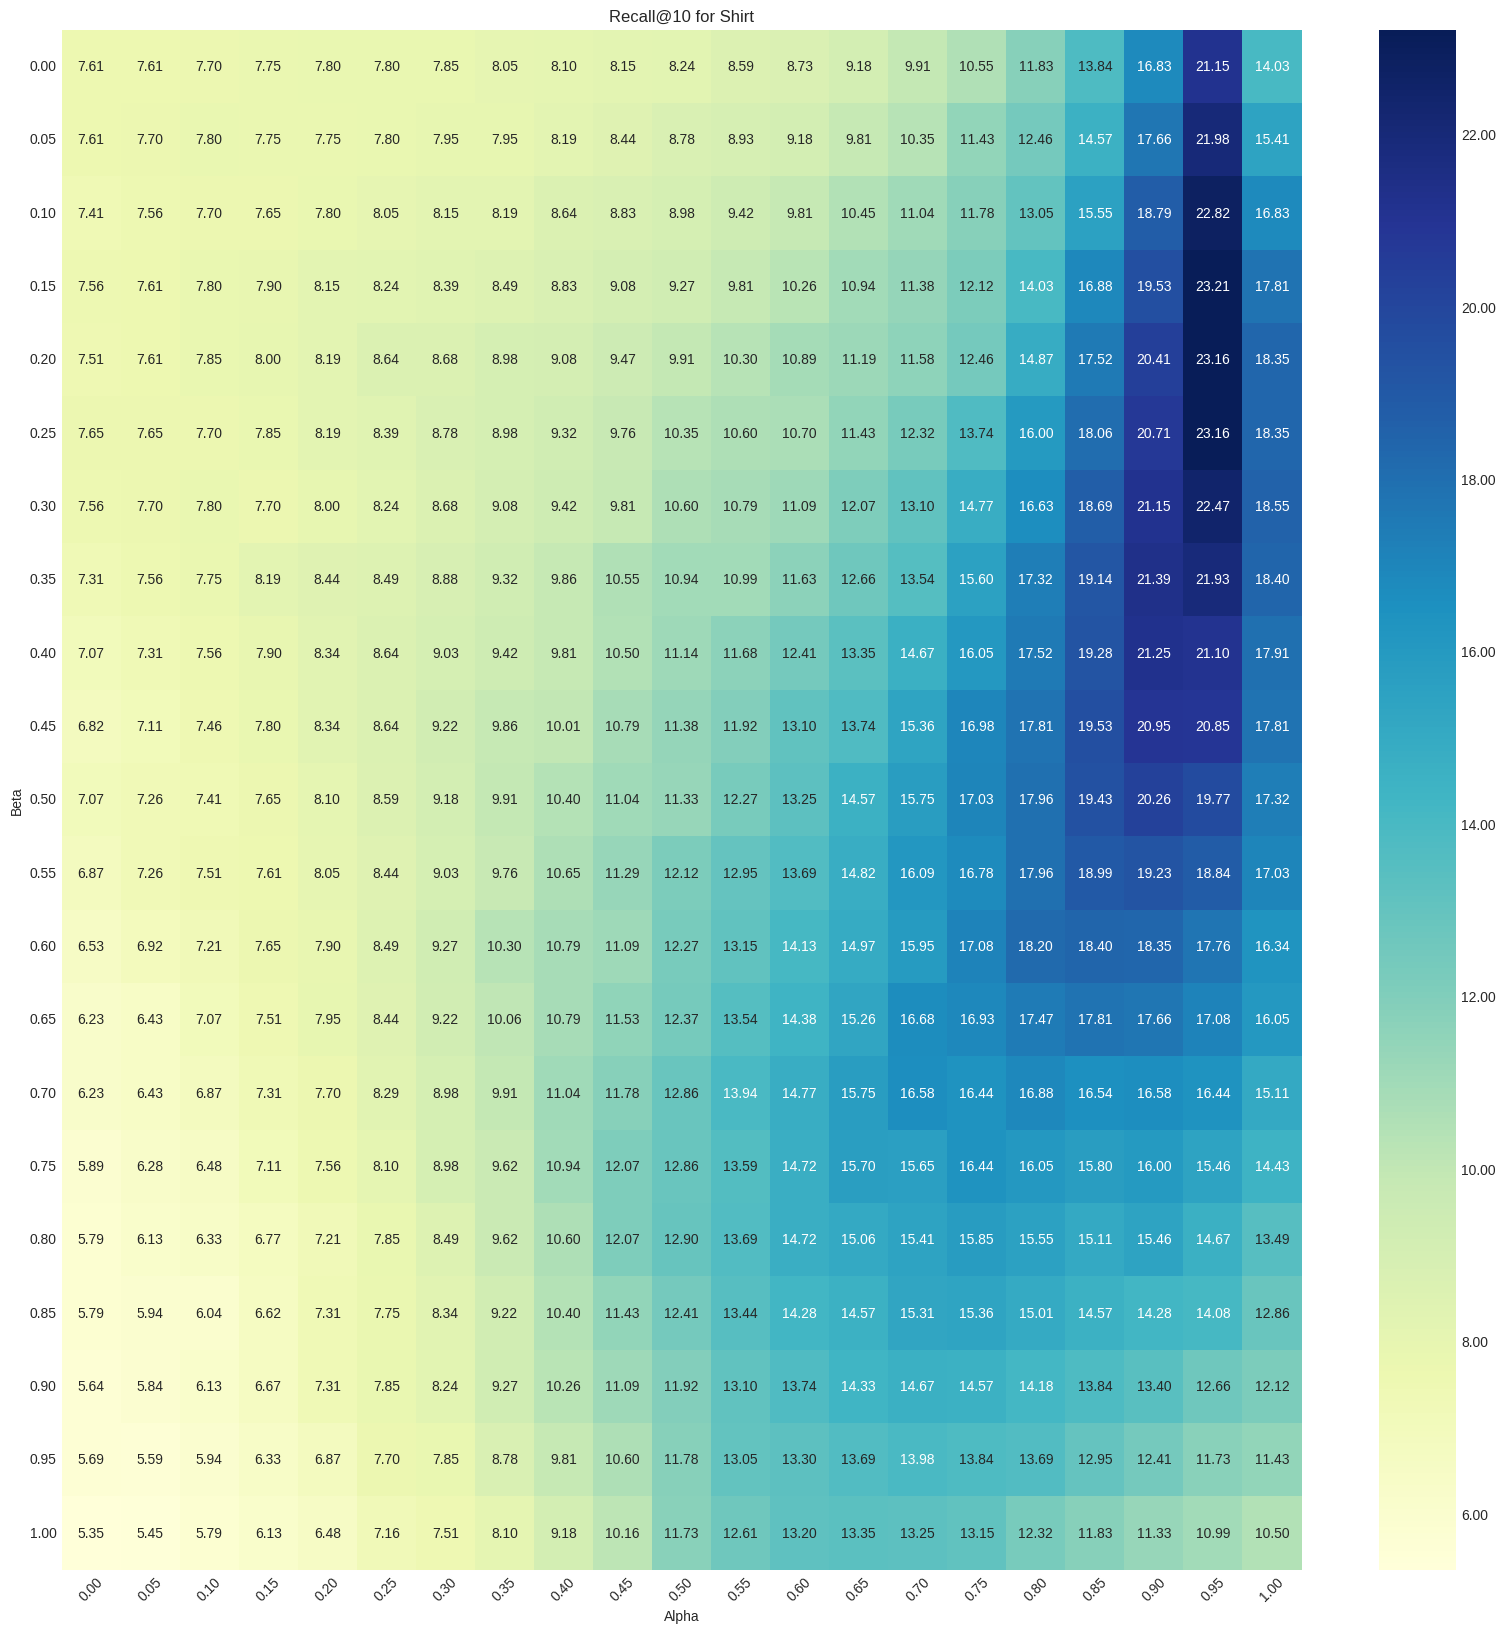

In [20]:
prepare_and_plot_recall_pivot(shirt_recall_at10, "Recall@10 for Shirt")

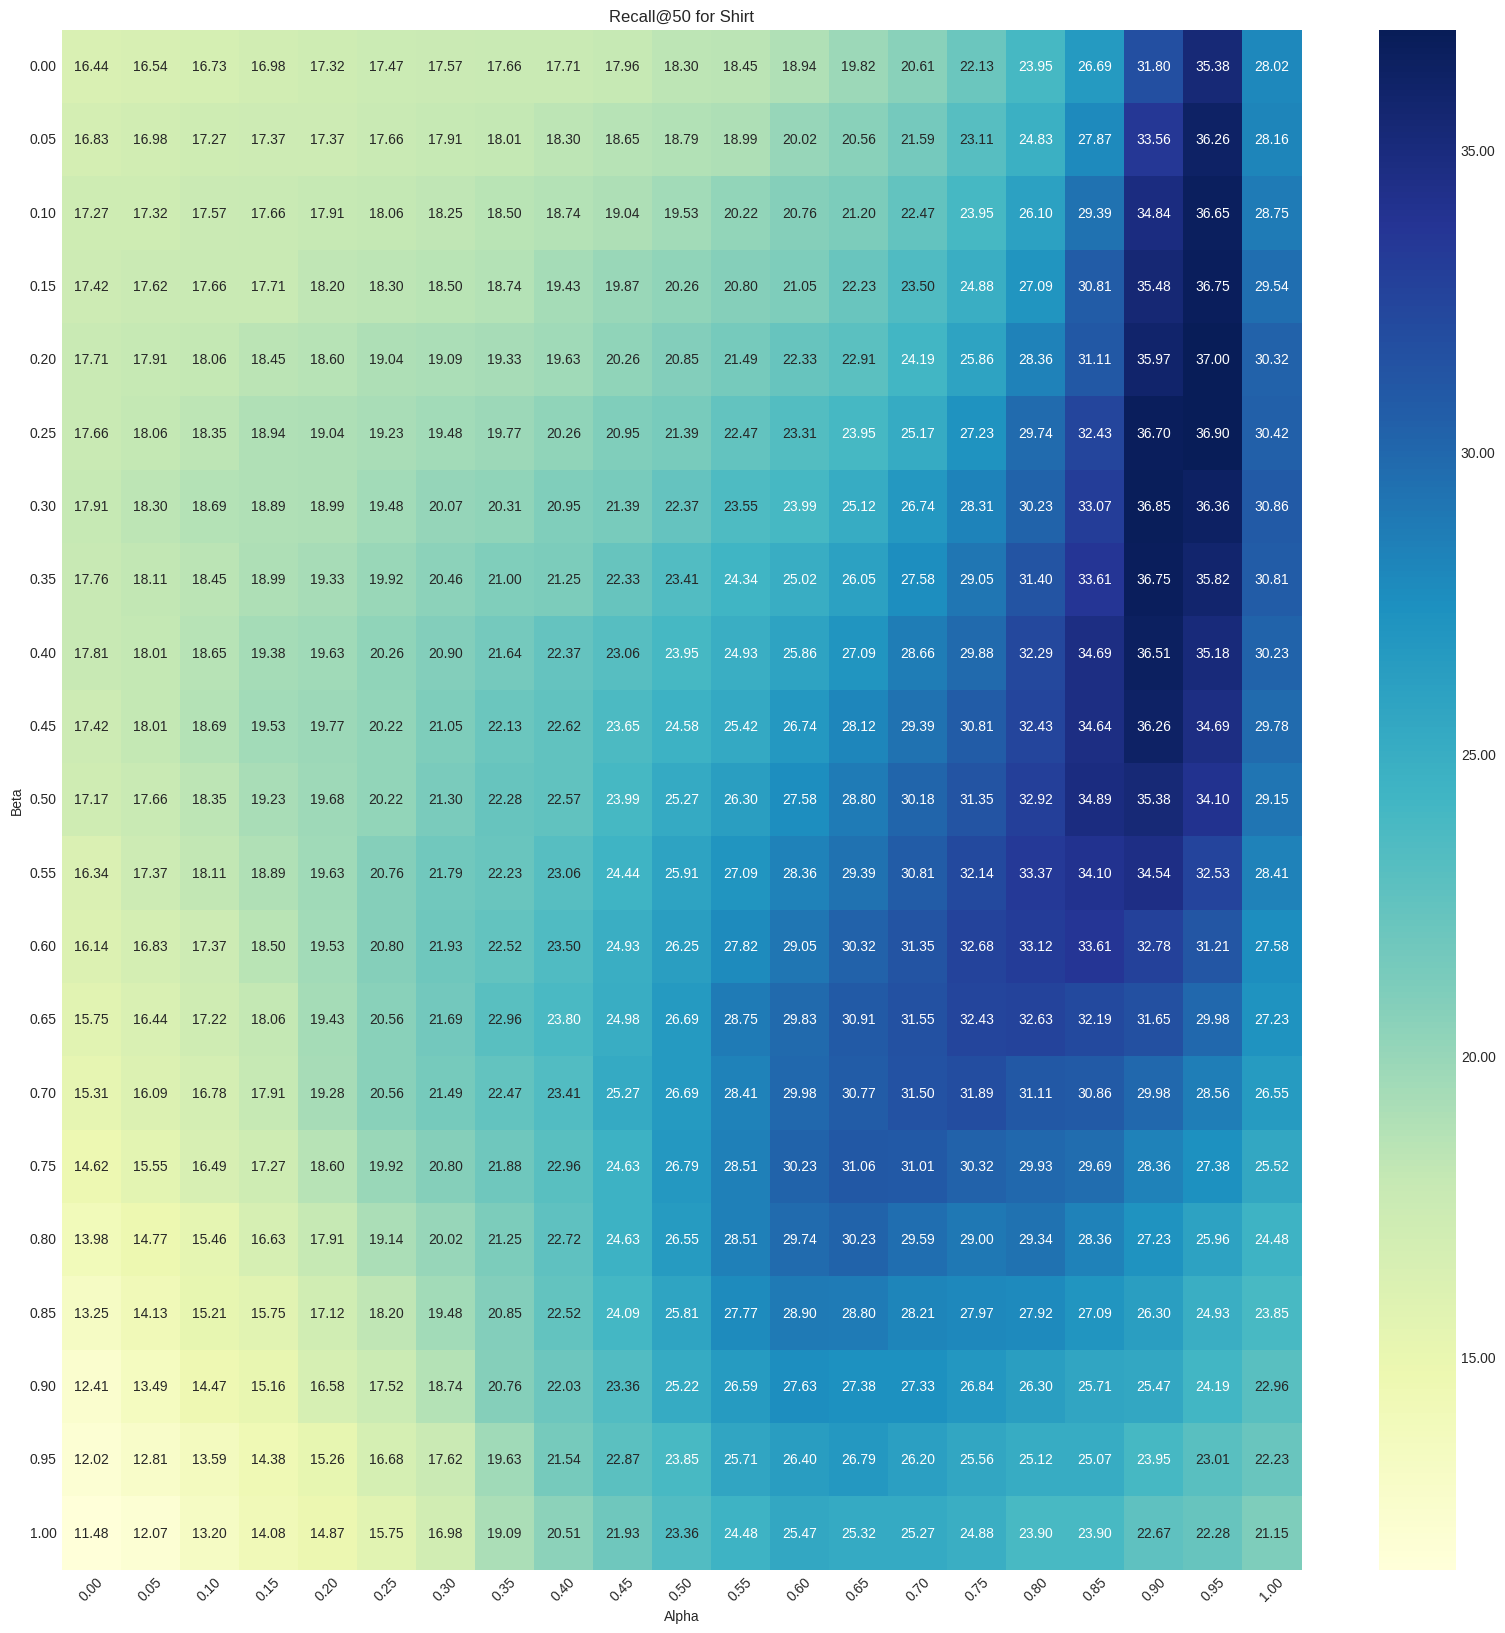

In [21]:
prepare_and_plot_recall_pivot(shirt_recall_at50, "Recall@50 for Shirt")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Dress</div>

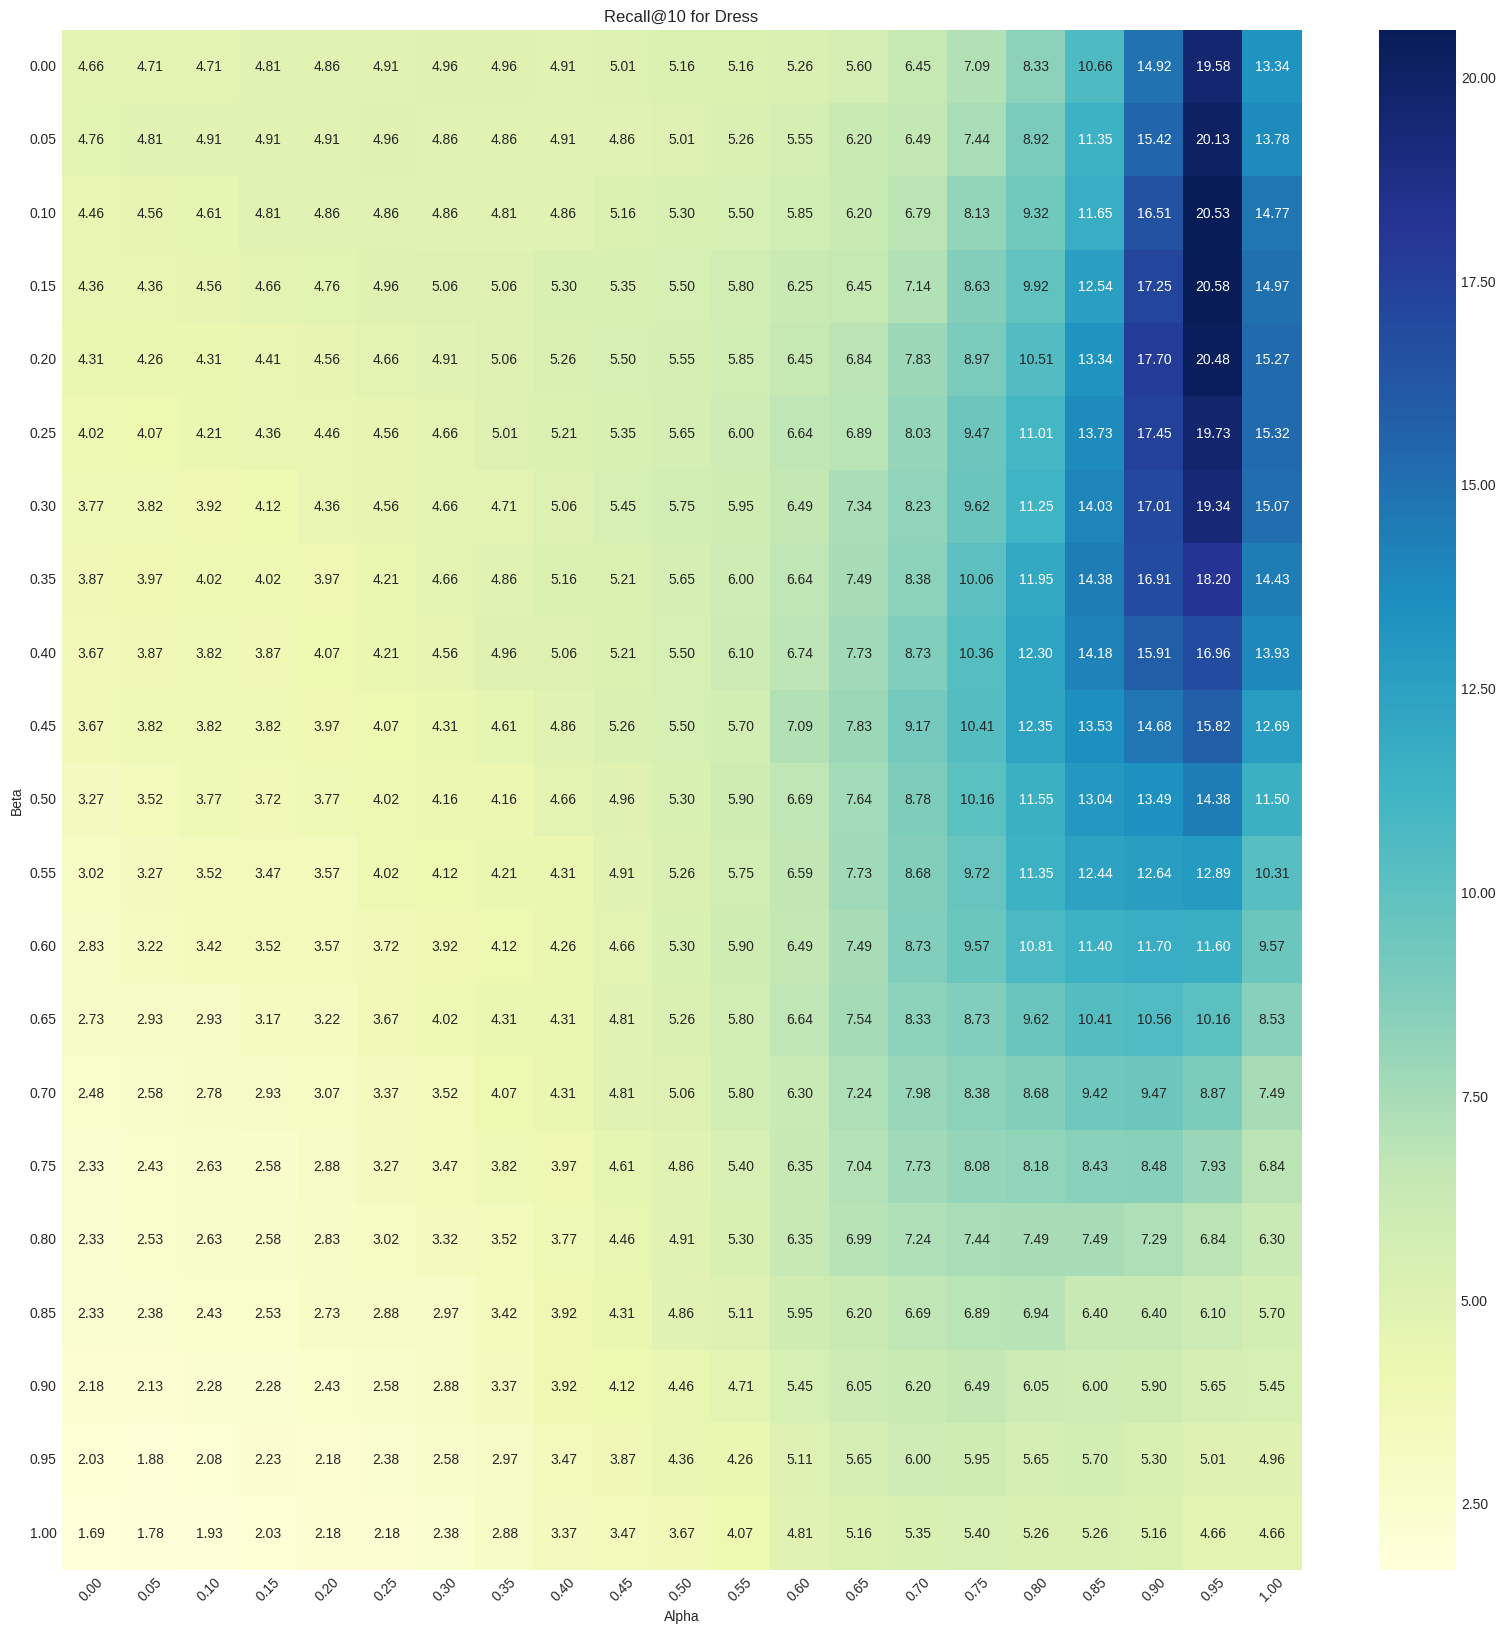

In [22]:
prepare_and_plot_recall_pivot(dress_recall_at10, "Recall@10 for Dress")

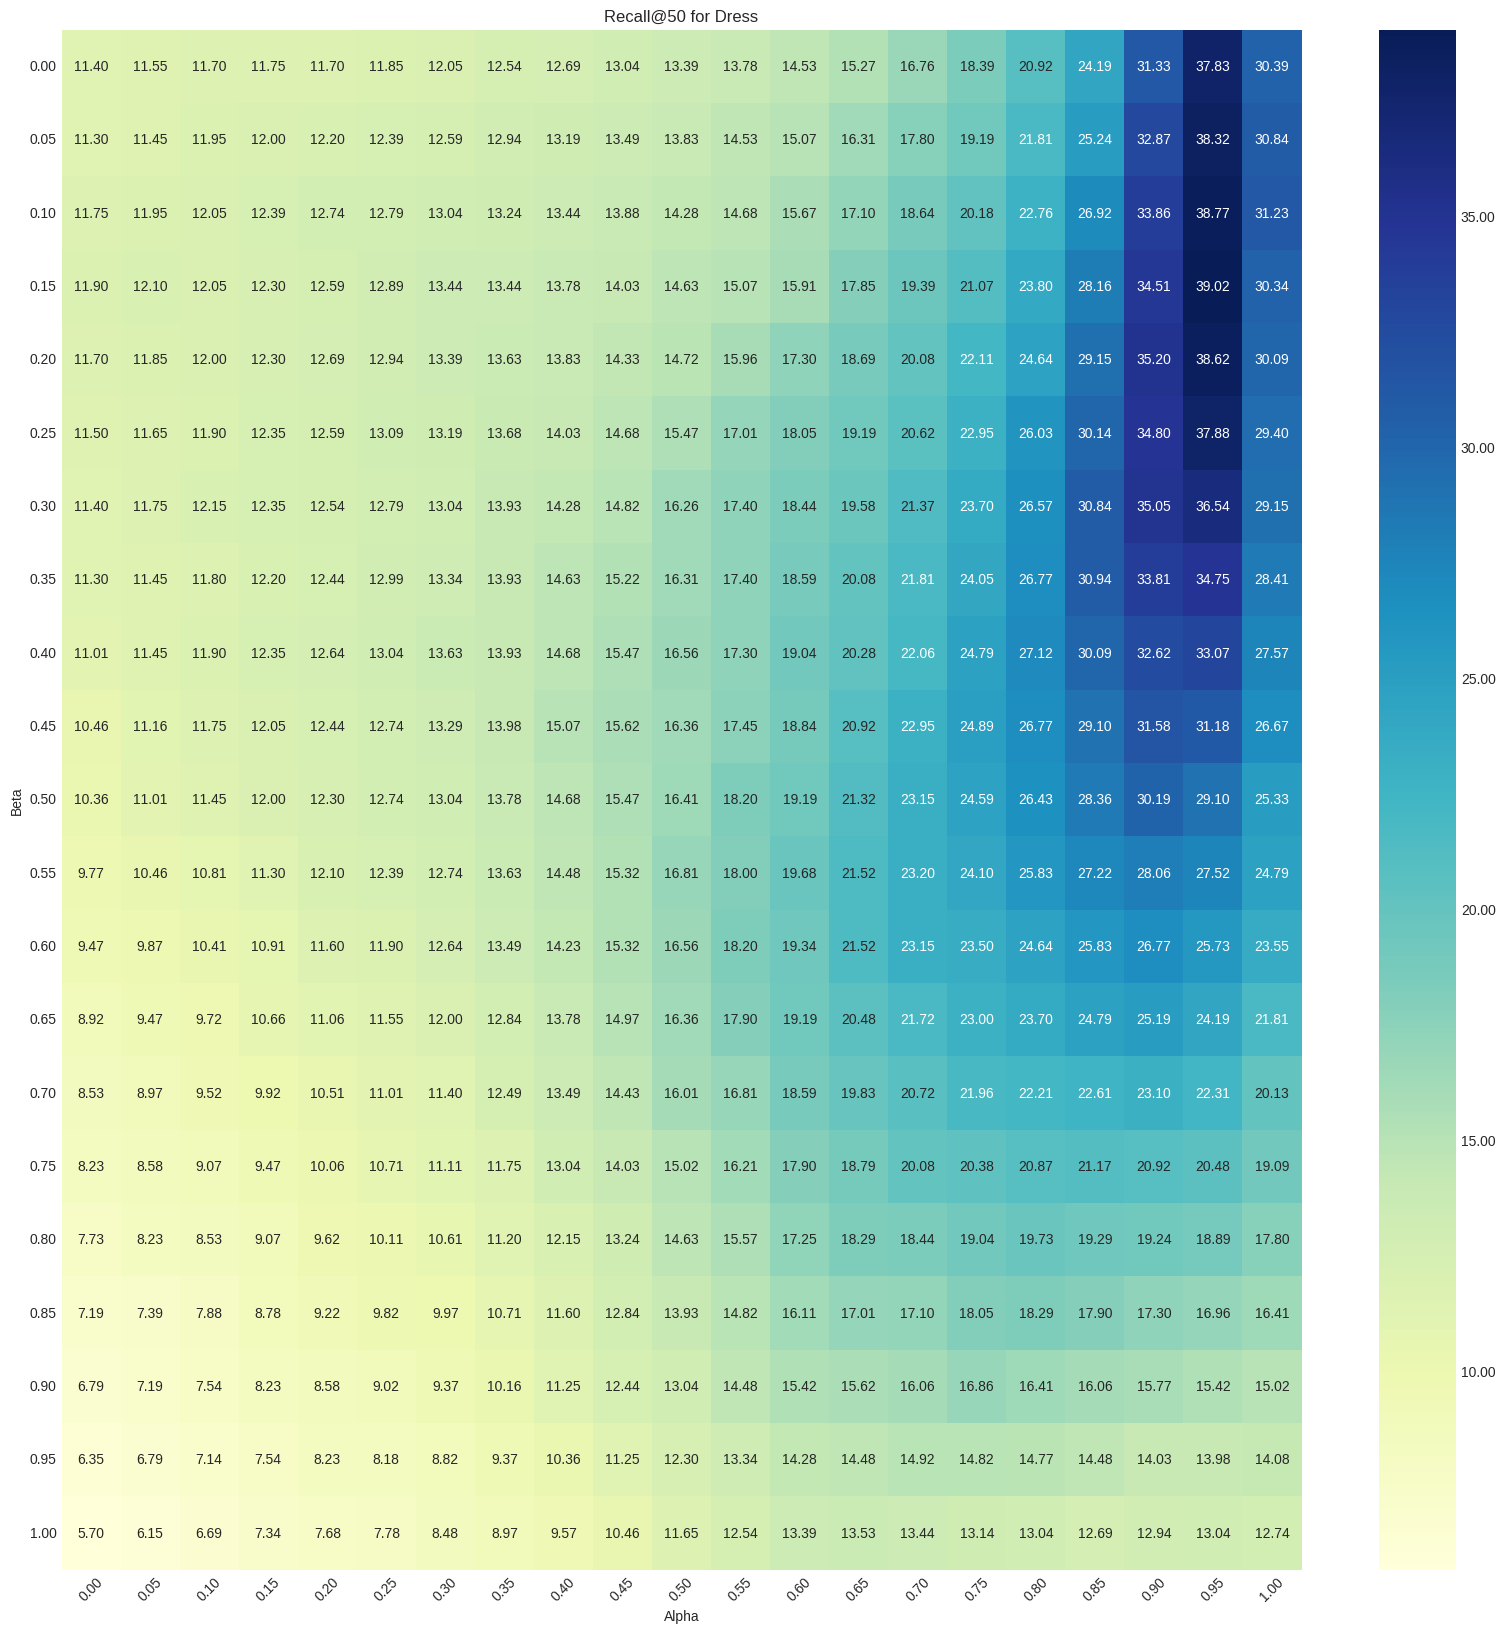

In [23]:
prepare_and_plot_recall_pivot(dress_recall_at50, "Recall@50 for Dress")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for TopTee</div>

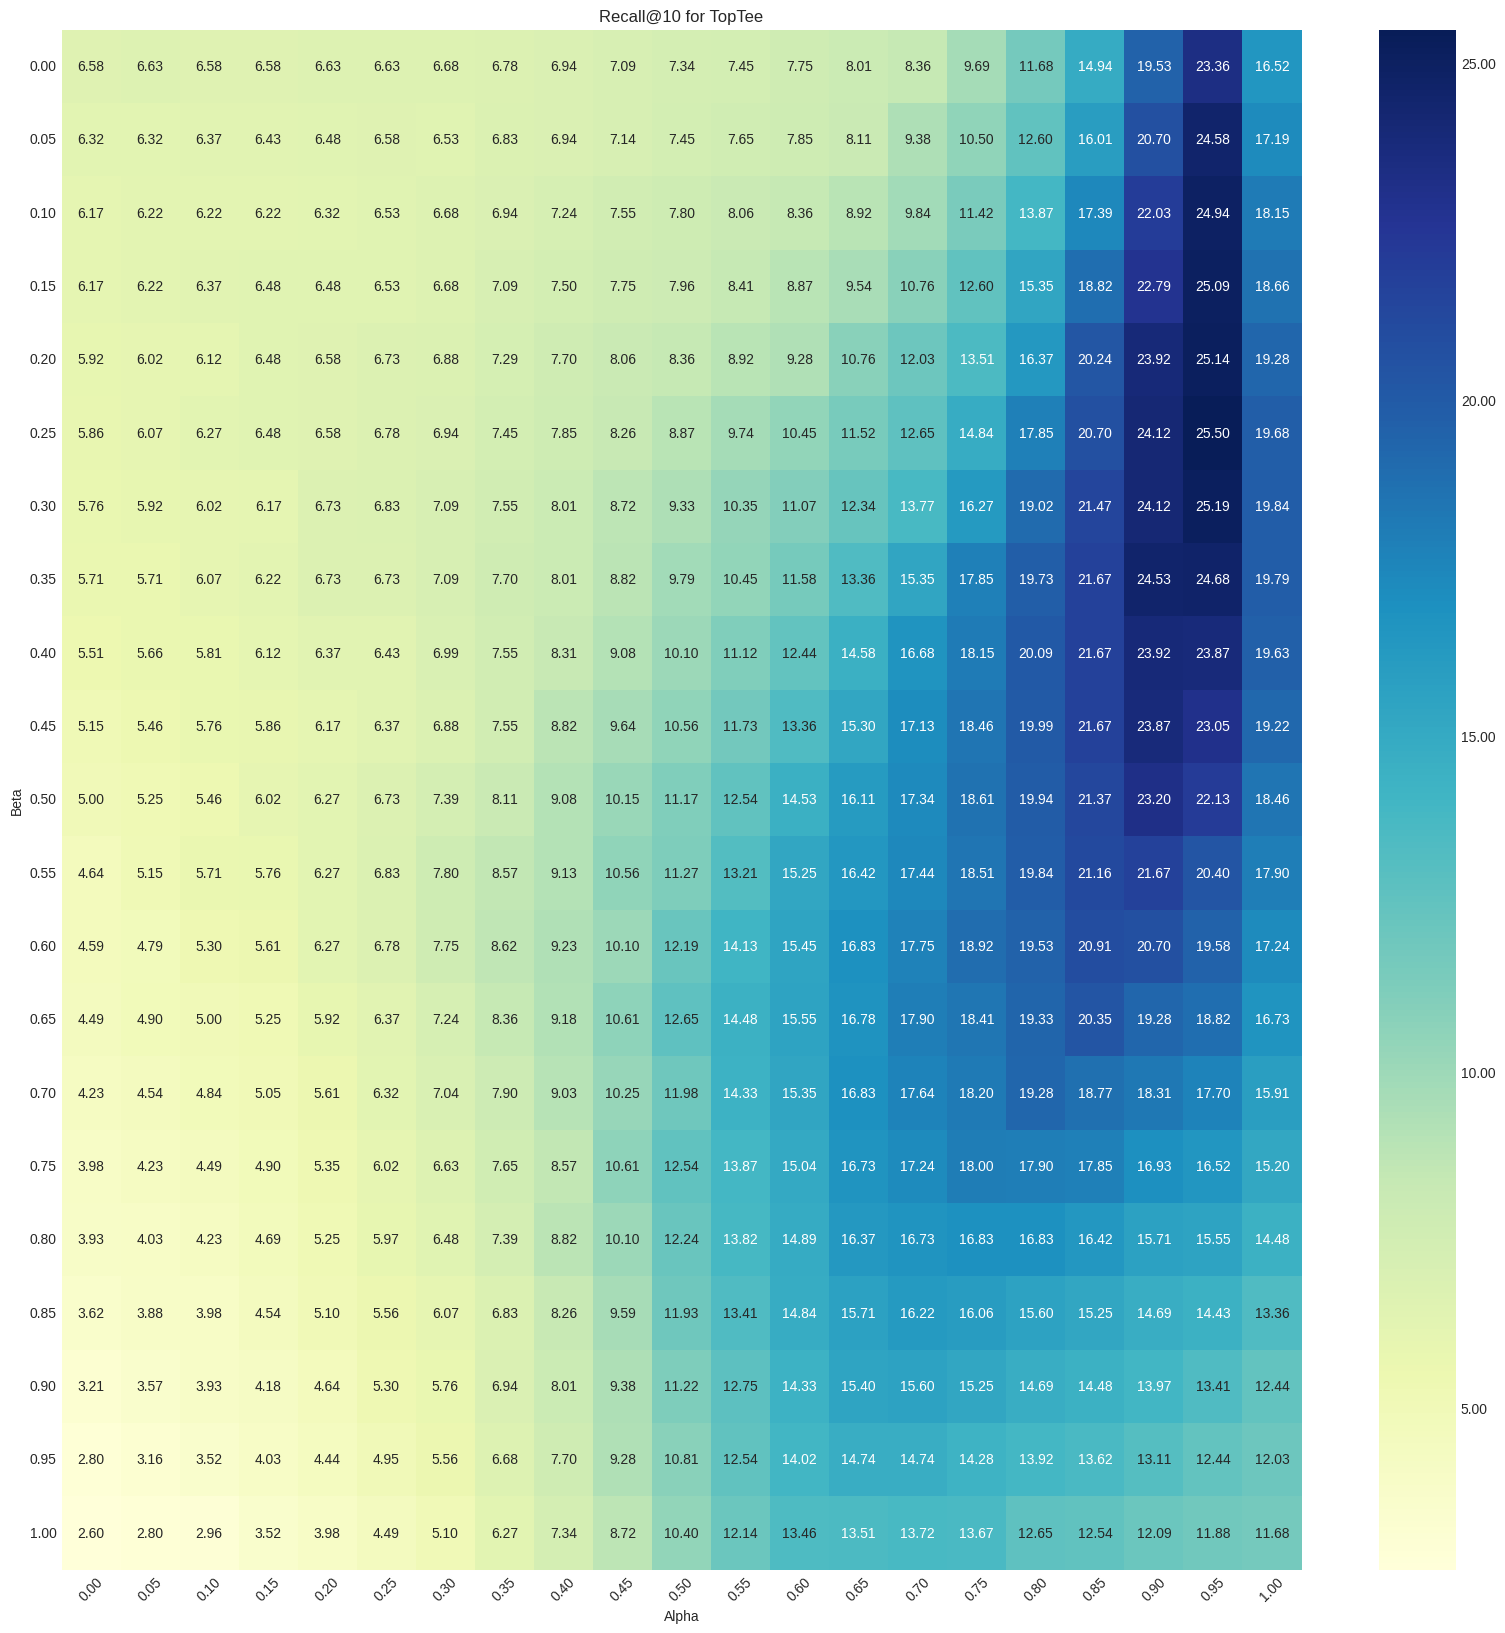

In [24]:
prepare_and_plot_recall_pivot(toptee_recall_at10, "Recall@10 for TopTee")

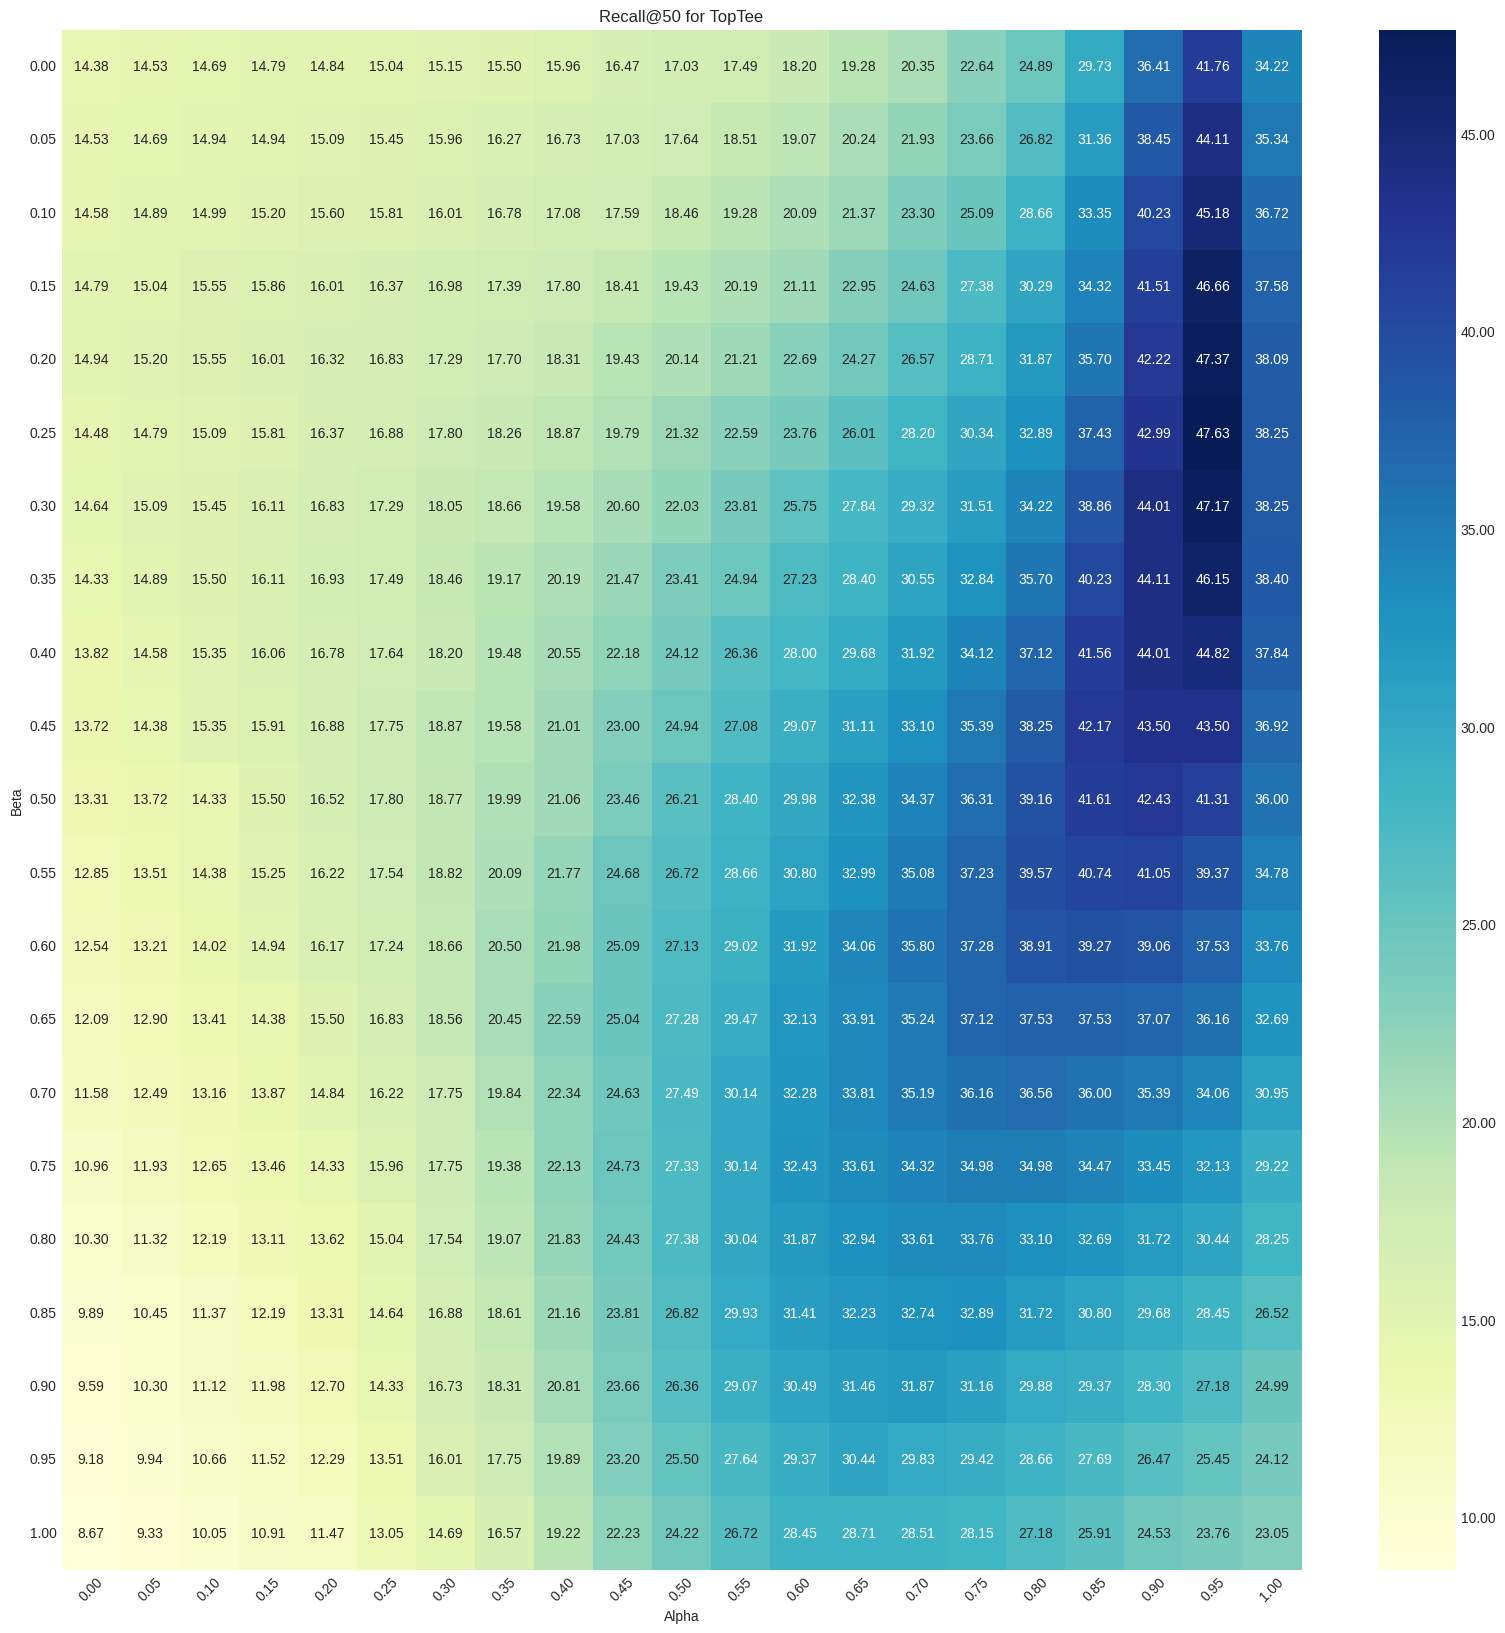

In [25]:
prepare_and_plot_recall_pivot(toptee_recall_at50, "Recall@50 for TopTee")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the average recall at 10 and 50 for all categories</div>

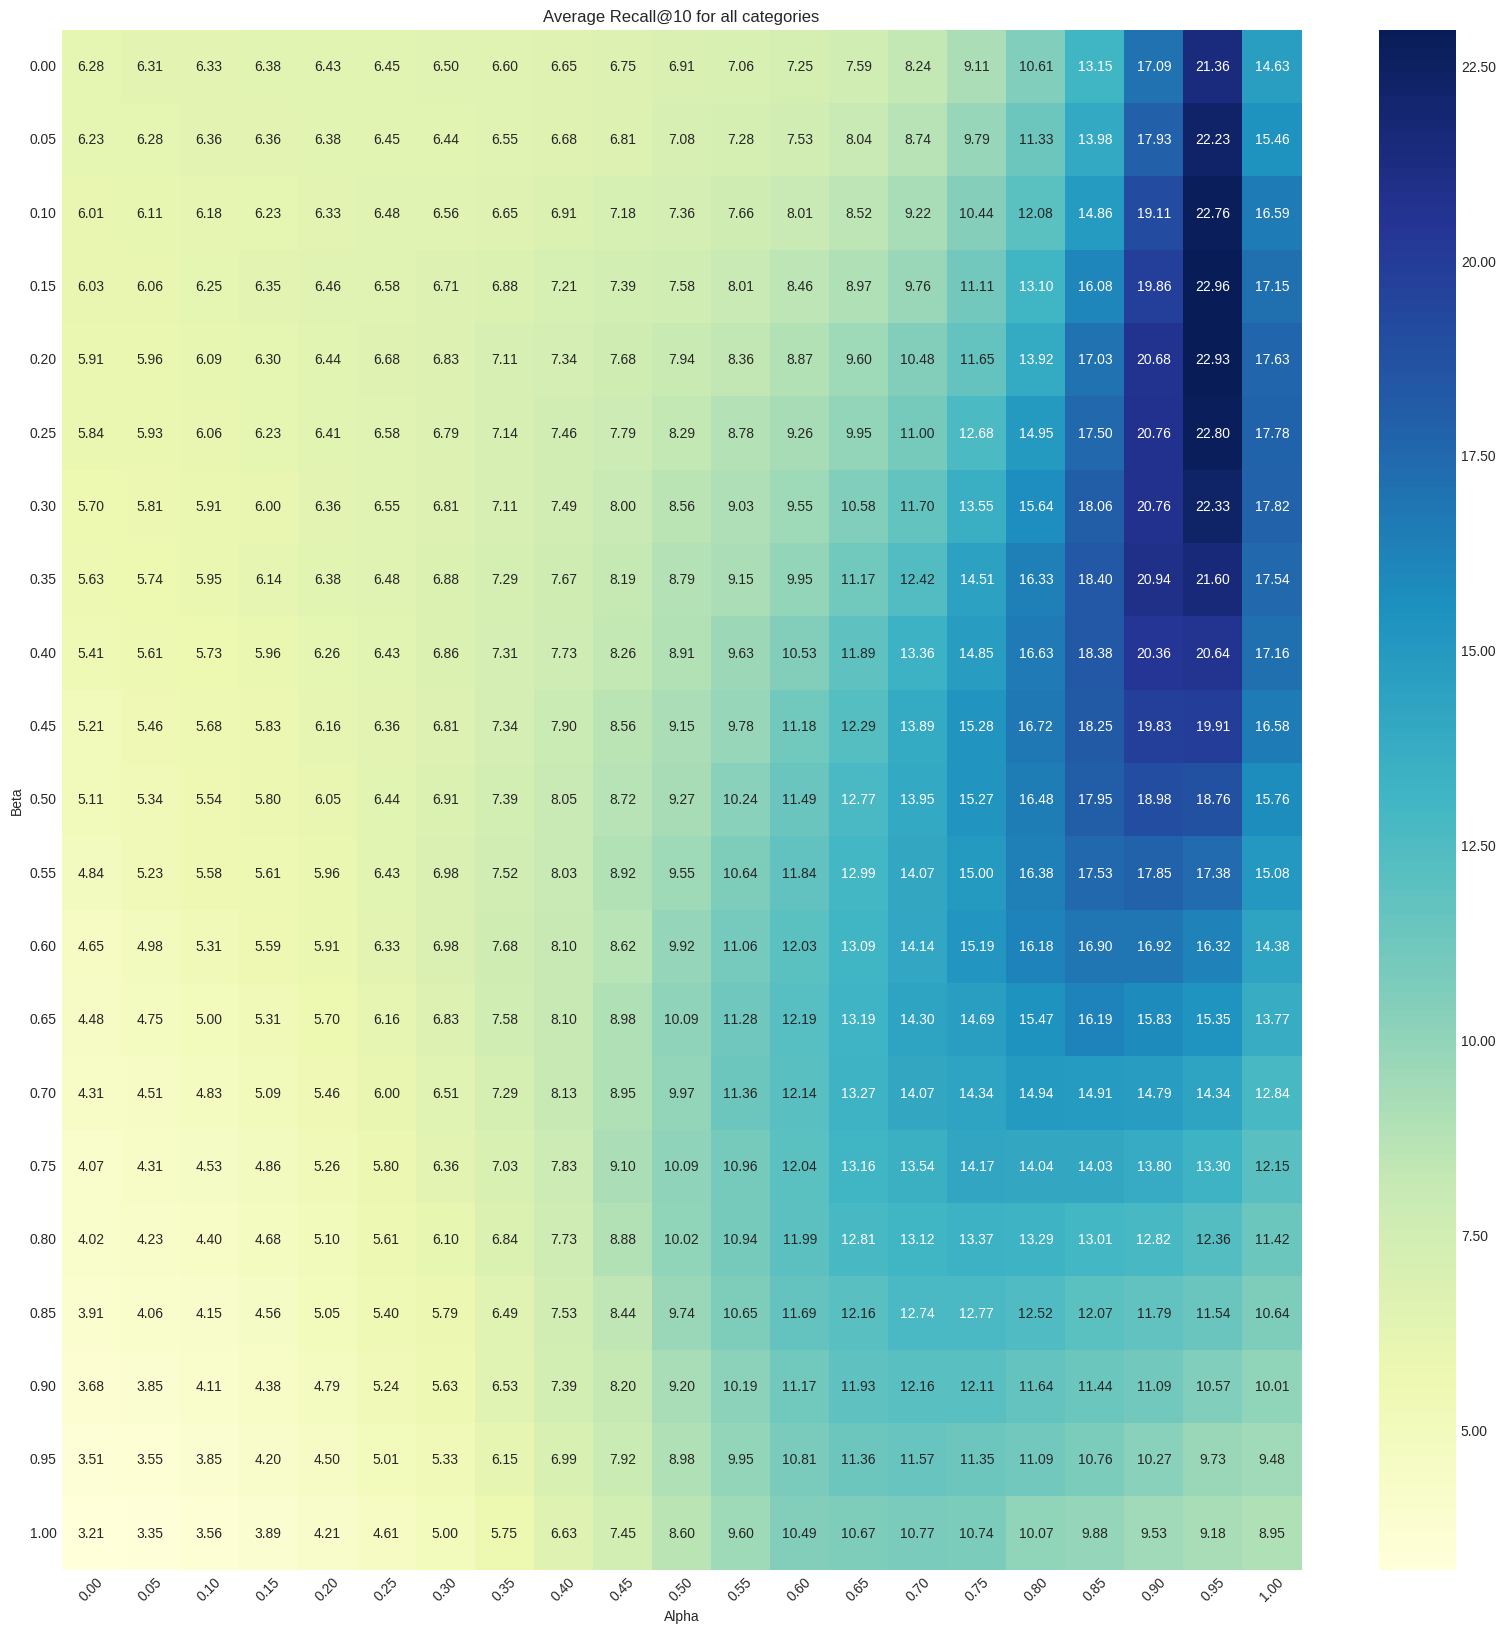

In [26]:
prepare_and_plot_recall_pivot(average_recall_at10, "Average Recall@10 for all categories")

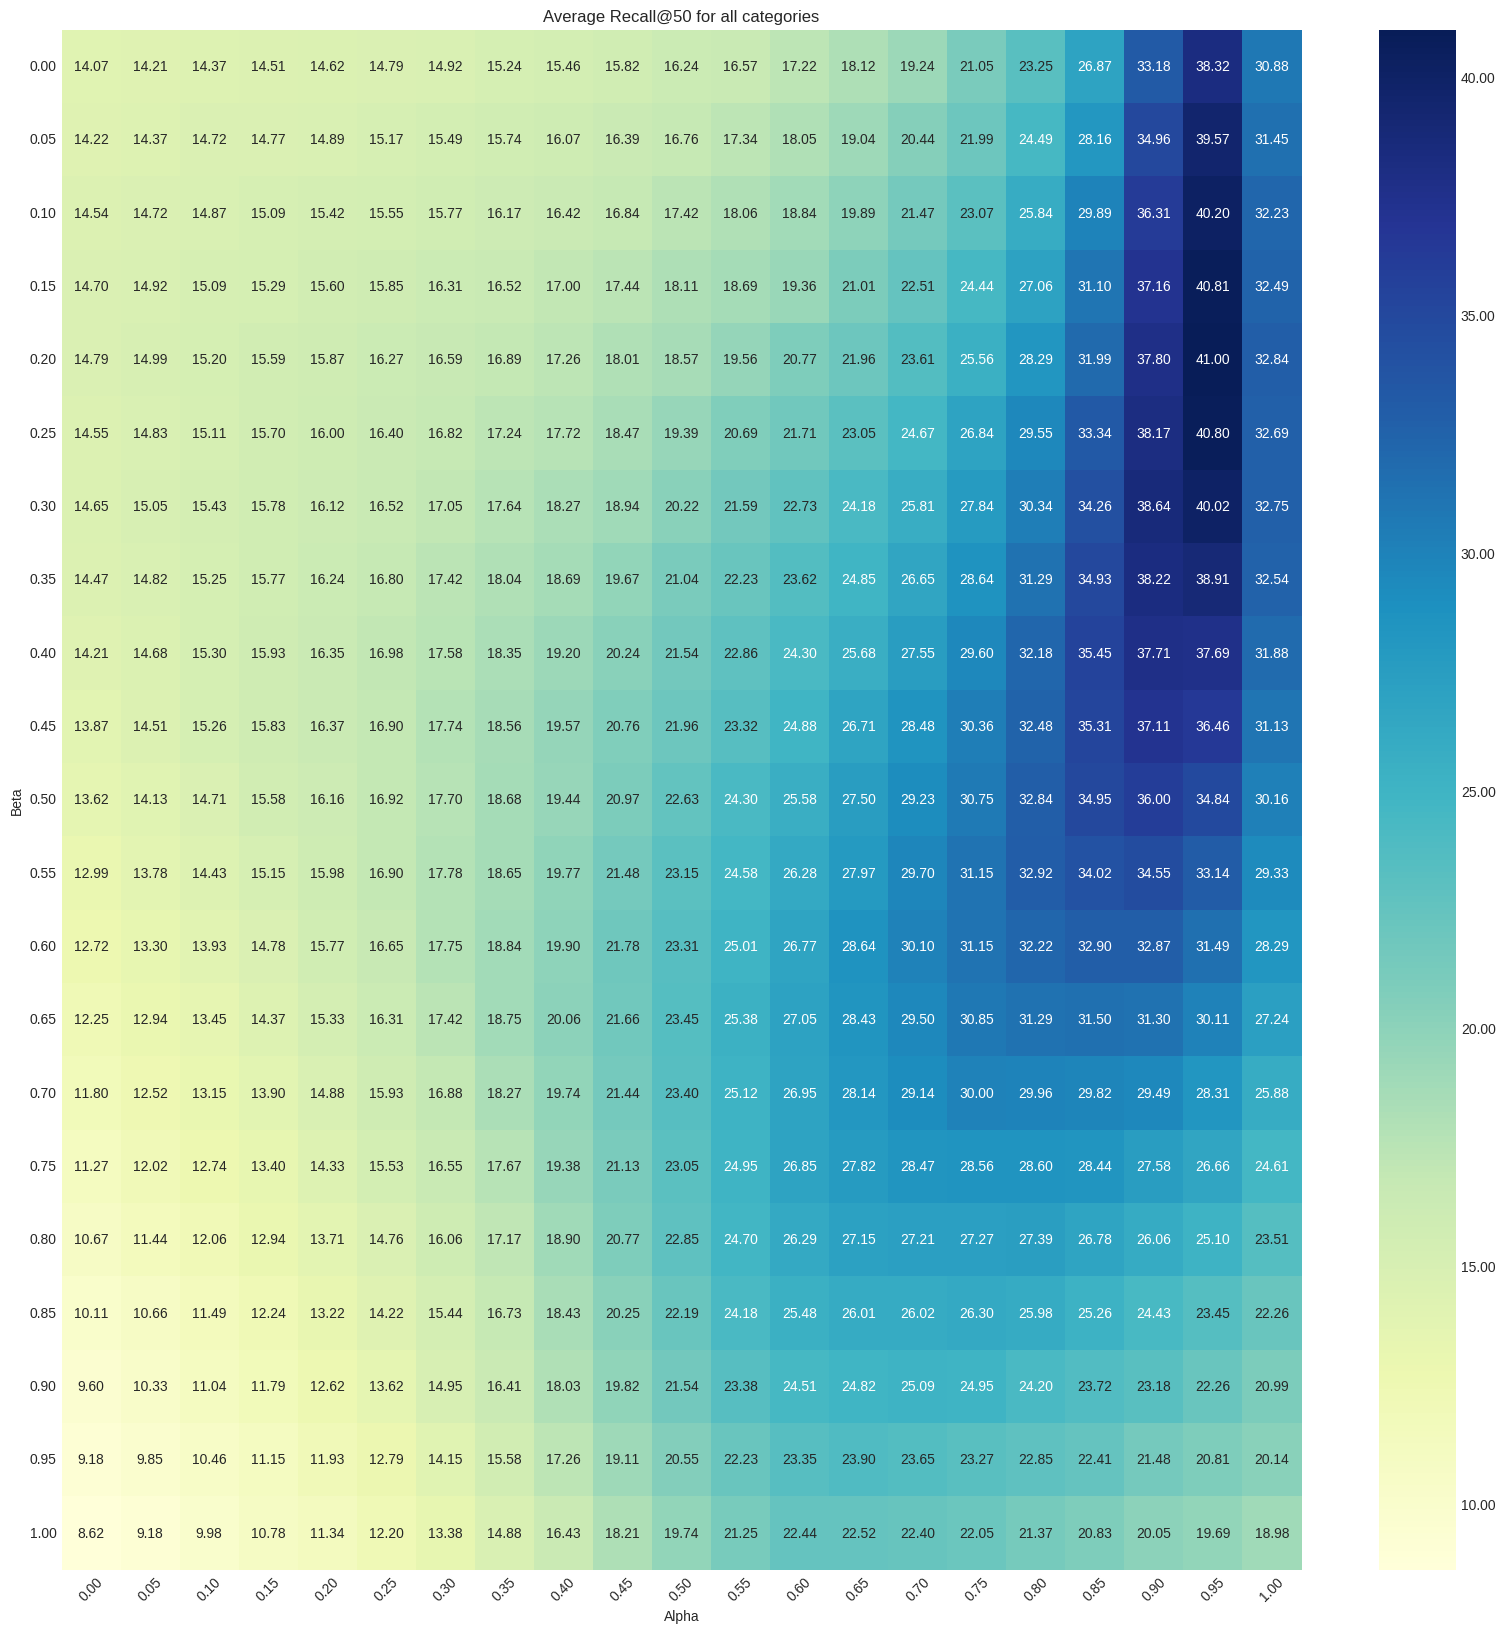

In [27]:
prepare_and_plot_recall_pivot(average_recall_at50, "Average Recall@50 for all categories")

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 5: View some sample of the result</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Shirt category</div>

In [29]:
sorted_indices_shirt, image_index_names_shirt, target_names_shirt = compute_results_fiq_val(
    'shirt',
    get_combing_function_with_alpha(0.95),
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0.2,
    cache=cache,
)

Recall at 10: 23.15996140241623
Recall at 50: 36.997056007385254


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Dress category</div>

In [28]:
sorted_indices_dress, image_index_names_dress, target_names_dress = compute_results_fiq_val(
    'dress',
    get_combing_function_with_alpha(0.95),
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0.2,
    cache=cache,
)

Recall at 10: 20.475953817367554
Recall at 50: 38.62171471118927


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the TopTee category</div>

In [30]:
sorted_indices_toptee, image_index_names_toptee, target_names_toptee = compute_results_fiq_val(
    'toptee',
    get_combing_function_with_alpha(0.95),
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0.2,
    cache=cache,
)

Recall at 10: 25.1402348279953
Recall at 50: 47.3737895488739


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Prepare the ground truth data</div>

In [37]:
ground_truth_dress = prepare_ground_truths(json.load(open('../../../fashionIQ_dataset/captions/cap.dress.val.json')))
ground_truth_shirt = prepare_ground_truths(json.load(open('../../../fashionIQ_dataset/captions/cap.shirt.val.json')))
ground_truth_toptee = prepare_ground_truths(json.load(open('../../../fashionIQ_dataset/captions/cap.toptee.val.json')))

DATASET_IMAGE_DIR = '../../../fashionIQ_dataset/images/'

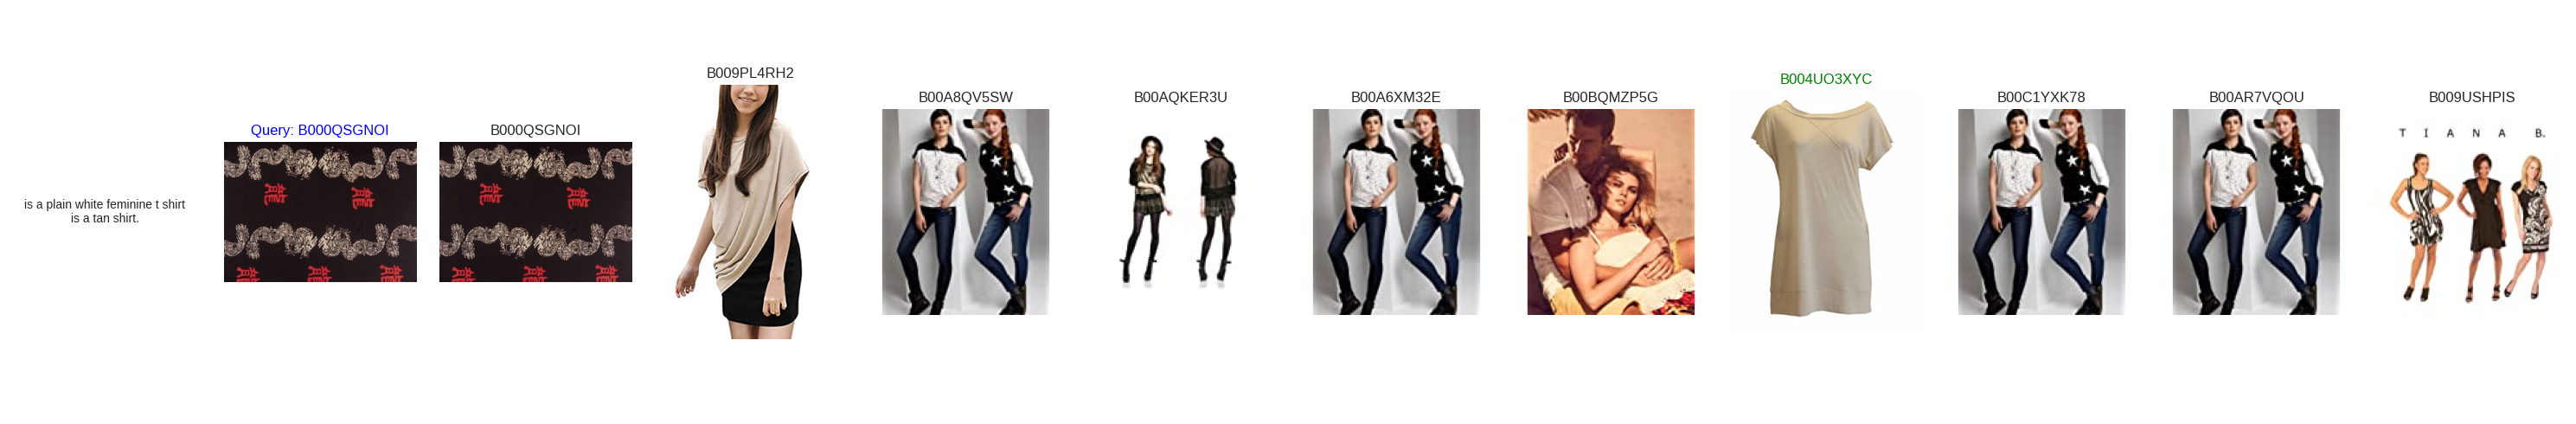

In [44]:
plot_retrieval_results_of_i(
    sorted_indices_dress, 
    image_index_names_dress, 
    target_names_dress, 
    ground_truth_dress, 
    top_k=10, 
    i=3,
    directory=DATASET_IMAGE_DIR,
)

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 6: Compare with the original without MMLM captions and identical weights element-wise sum</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Shirt category</div>

In [46]:
sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin = compute_results_fiq_val(
    'shirt',
    combining_function_original,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0,
    cache=cache,
)

Recall at 10: 8.243376016616821
Recall at 50: 18.302257359027863


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Dress category</div>

In [45]:
sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin = compute_results_fiq_val(
    'dress',
    combining_function_original,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0,
    cache=cache,
)

Recall at 10: 5.156172439455986
Recall at 50: 13.386216759681702


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the TopTee category</div>

In [47]:
sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin = compute_results_fiq_val(
    'toptee',
    combining_function_original,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0,
    cache=cache,
)

Recall at 10: 7.343192398548126
Recall at 50: 17.03212708234787


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the Shirt category</div>

In [51]:
become_better = found_better_than_original(
    sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin,
    sorted_indices_shirt, image_index_names_shirt, target_names_shirt,
    top_k=10
)

len(become_better), become_better[:10]

(386, [1, 6, 8, 11, 13, 19, 20, 34, 40, 42])

In [52]:
become_worse = found_better_than_original(
    sorted_indices_shirt, image_index_names_shirt, target_names_shirt,
    sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(74, [5, 10, 84, 133, 150, 183, 187, 195, 222, 258])

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the Dress category</div>

In [49]:
become_better = found_better_than_original(
    sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin,
    sorted_indices_dress, image_index_names_dress, target_names_dress,
    top_k=10
)

len(become_better), become_better[:10]

(371, [3, 10, 11, 16, 27, 33, 34, 52, 54, 56])

In [50]:
become_worse = found_better_than_original(
    sorted_indices_dress, image_index_names_dress, target_names_dress,
    sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(51, [6, 13, 61, 109, 169, 215, 218, 262, 308, 419])

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the TopTee category</div>

In [53]:
become_better = found_better_than_original(
    sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin,
    sorted_indices_toptee, image_index_names_toptee, target_names_toptee,
    top_k=10
)

len(become_better), become_better[:10]

(433, [2, 3, 9, 10, 13, 15, 16, 18, 24, 28])

In [54]:
become_worse = found_better_than_original(
    sorted_indices_toptee, image_index_names_toptee, target_names_toptee,
    sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(65, [0, 32, 44, 63, 117, 132, 241, 292, 377, 379])

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 7: Visualize the comparison</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the Shirt category</div>

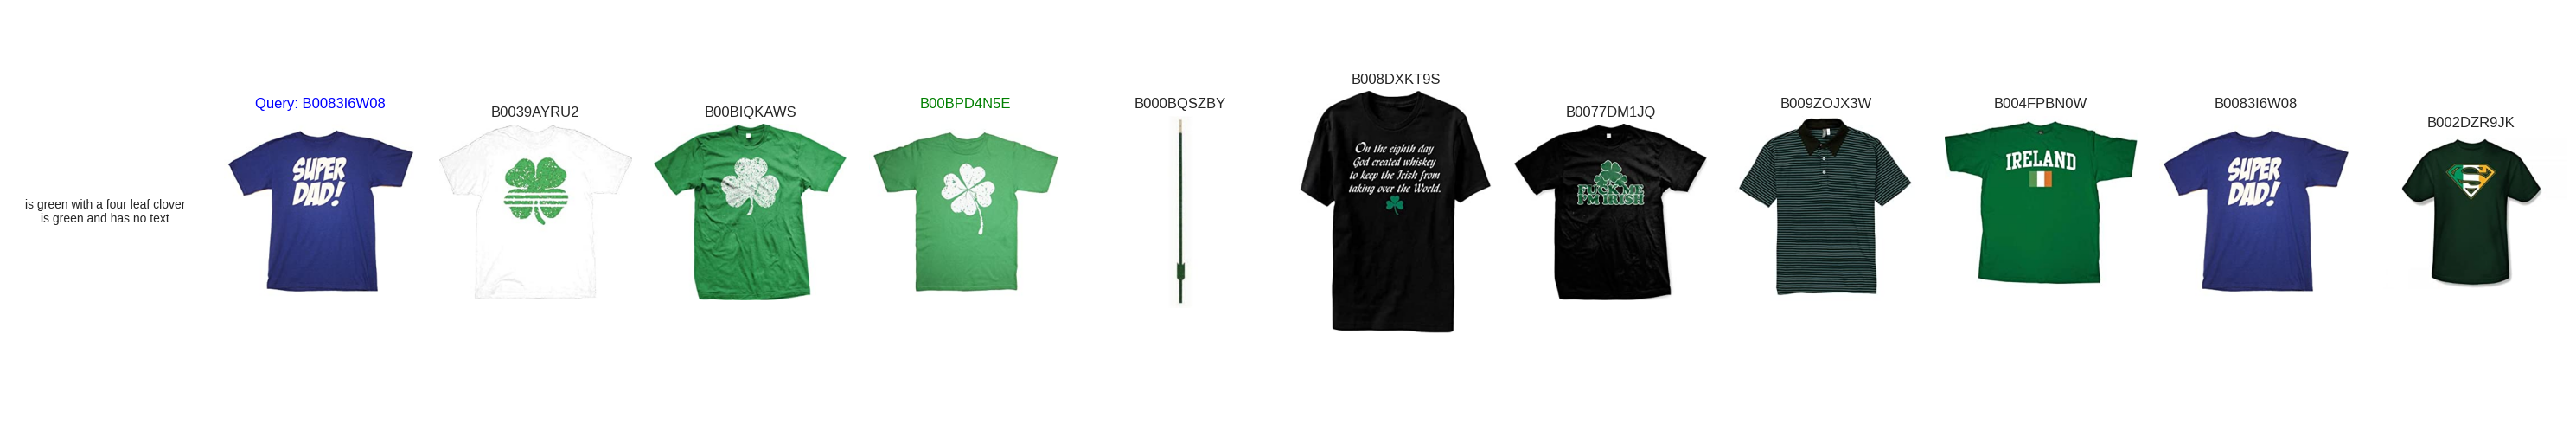

In [57]:
plot_retrieval_results_of_i(sorted_indices_shirt, image_index_names_shirt, target_names_shirt, ground_truth_shirt, top_k=10, i=1, directory=DATASET_IMAGE_DIR)

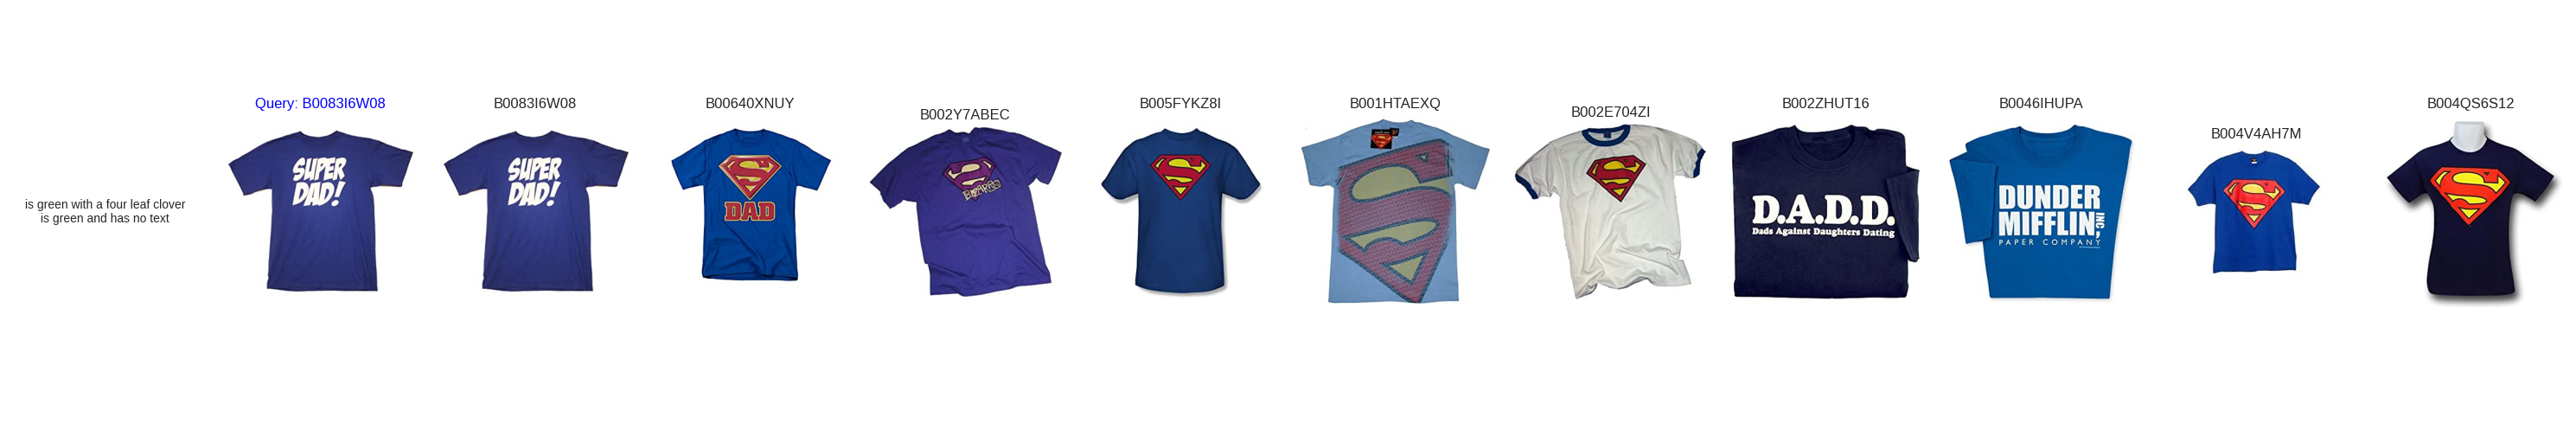

In [58]:
plot_retrieval_results_of_i(sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin, ground_truth_shirt, top_k=10, i=1, directory=DATASET_IMAGE_DIR)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the Dress category</div>

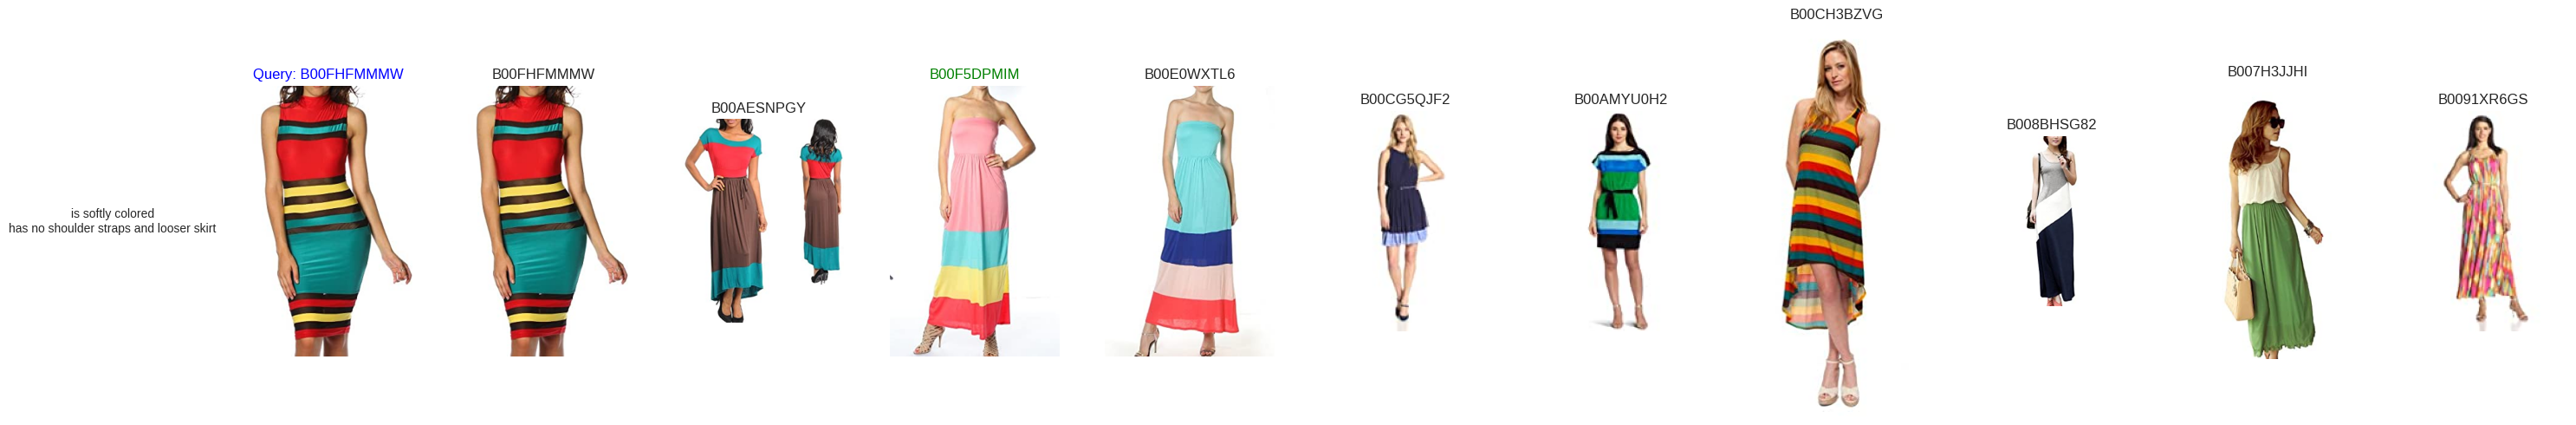

In [55]:
plot_retrieval_results_of_i(sorted_indices_dress, image_index_names_dress, target_names_dress, ground_truth_dress, top_k=10, i=11, directory=DATASET_IMAGE_DIR)

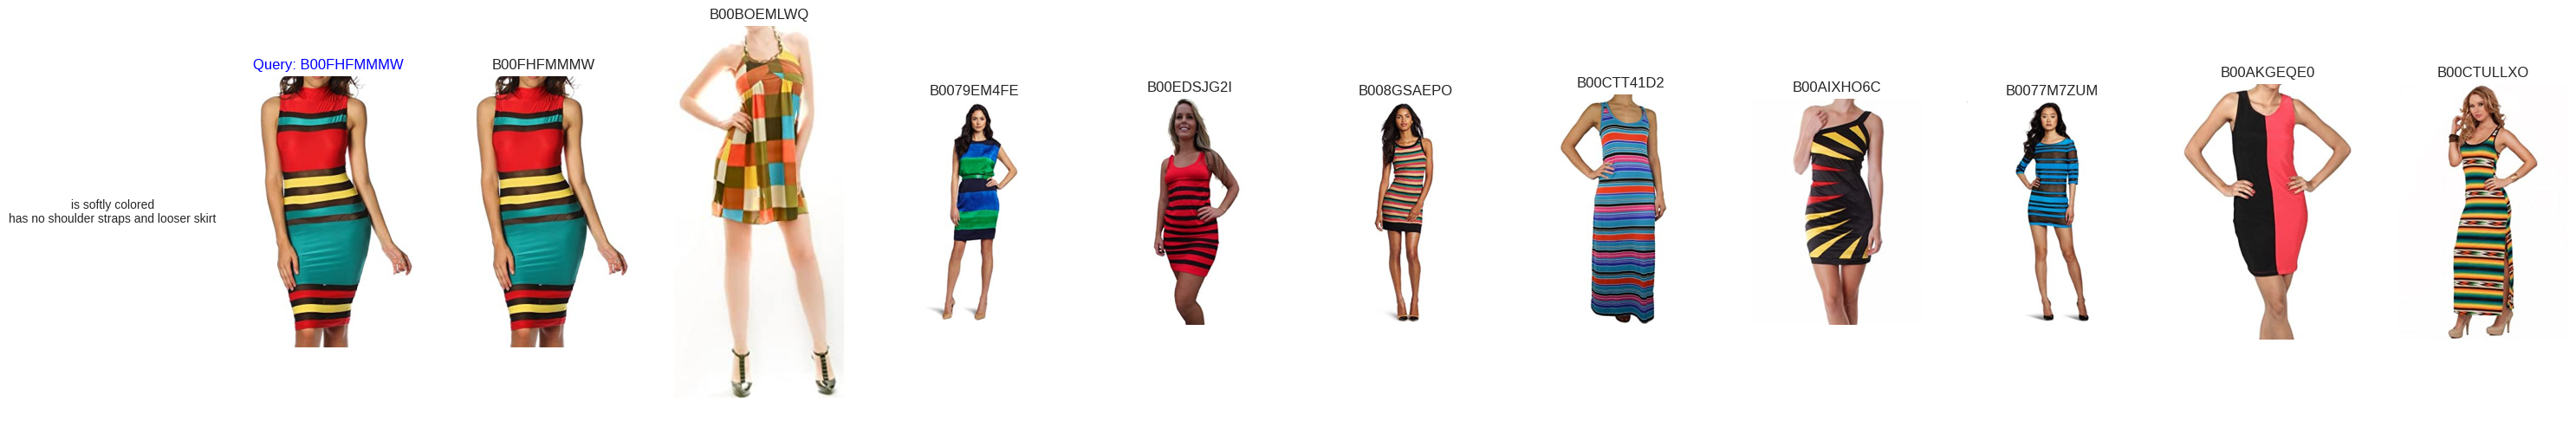

In [56]:
plot_retrieval_results_of_i(sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin, ground_truth_dress, top_k=10, i=11, directory=DATASET_IMAGE_DIR)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the TopTee category</div>

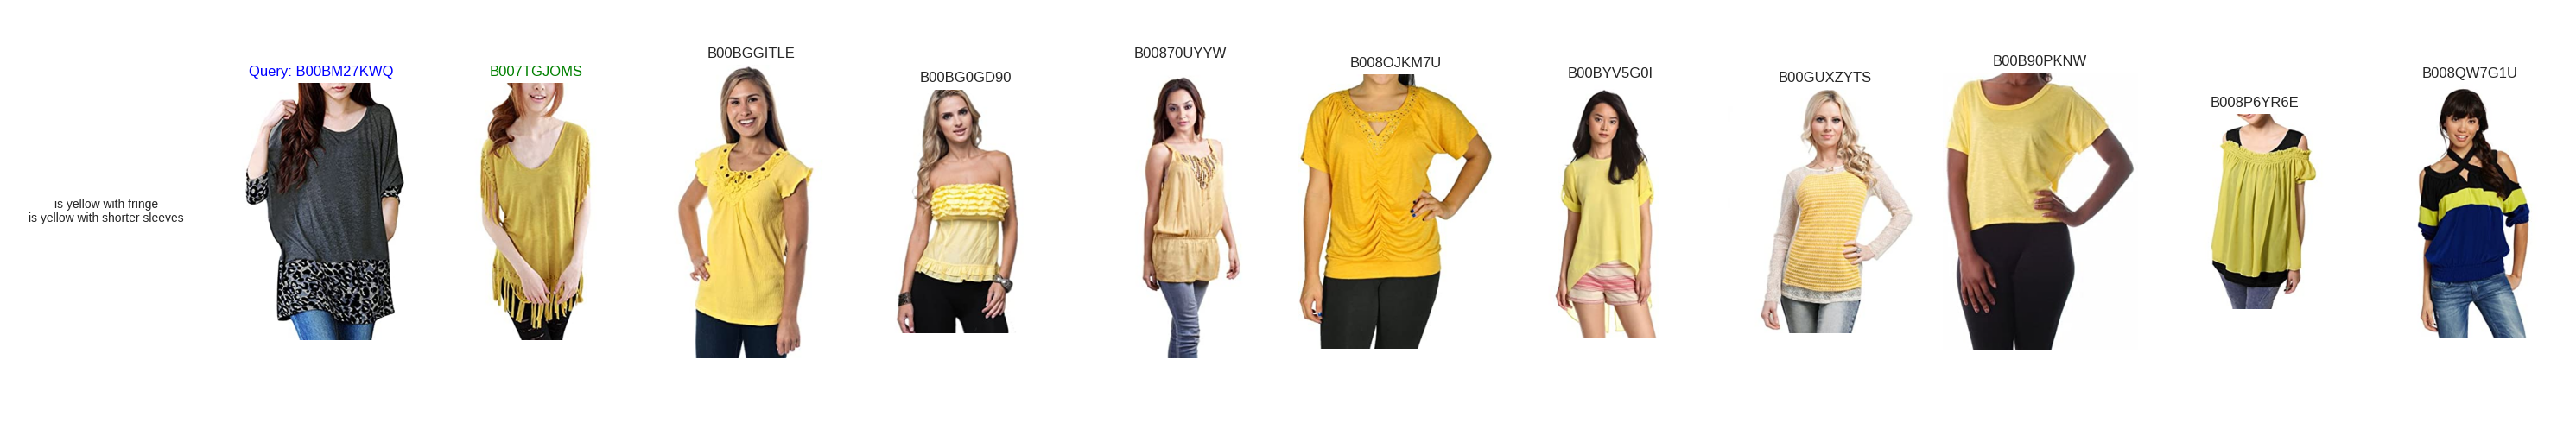

In [59]:
plot_retrieval_results_of_i(sorted_indices_toptee, image_index_names_toptee, target_names_toptee, ground_truth_toptee, top_k=10, i=2, directory=DATASET_IMAGE_DIR)

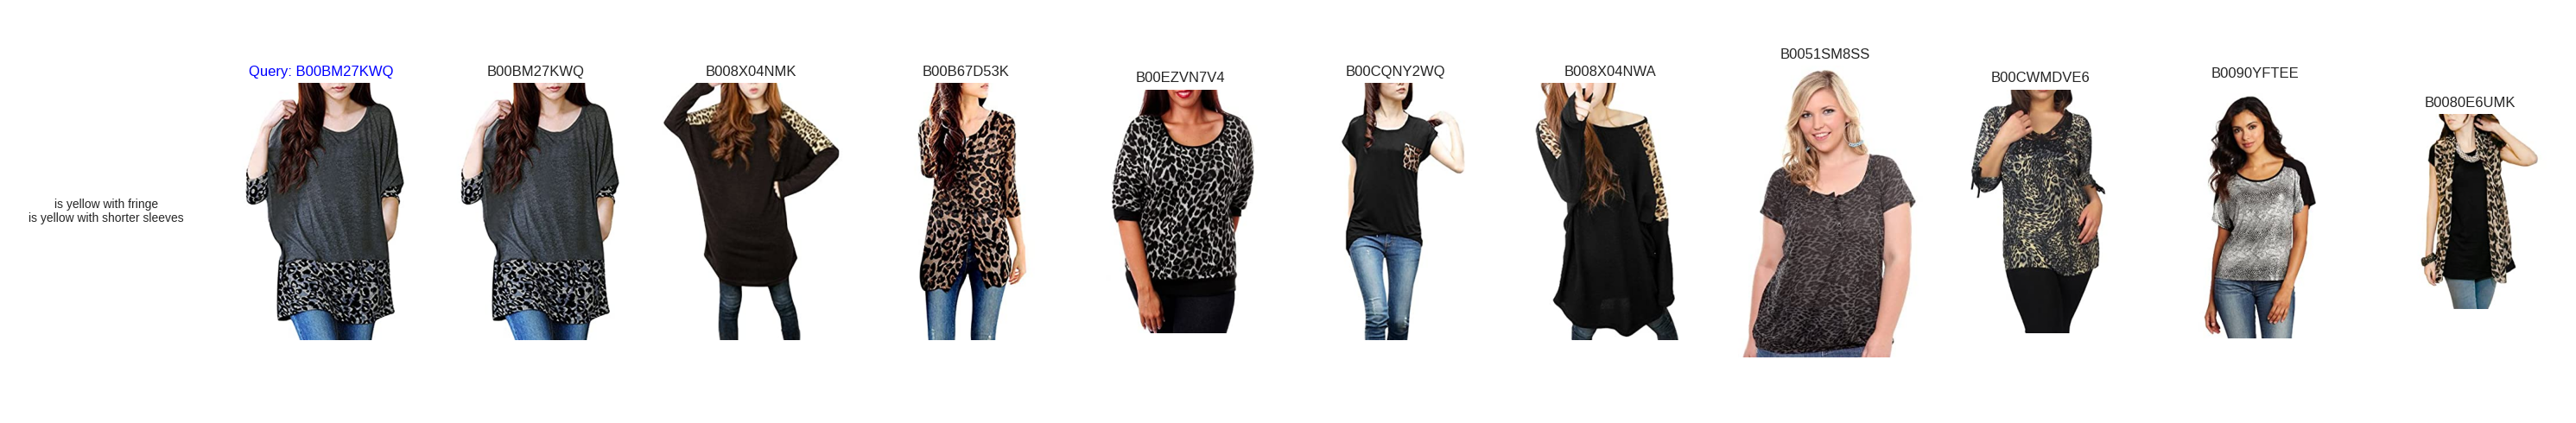

In [60]:
plot_retrieval_results_of_i(sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin, ground_truth_toptee, top_k=10, i=2, directory=DATASET_IMAGE_DIR)